#### Imports

In [361]:
import pandas as pd
import matplotlib
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import statsmodels.api as sm

from utils import market_values, market_values_links, market_values_by_time_index, market_values_links_con, congestion_rent_link, convert_ISO_3166_2_to_1, generation, generation_links, market_values_storage_units, generation_storage_units

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [362]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [363]:
# sort carriers by similar technology / underlying energy for better investigation
car_bus_el = ['AC','battery','Li ion','low voltage','home battery' ]
car_bus_heat = ['residential rural heat', 'services rural heat','residential urban decentral heat', 'services urban decentral heat', 'urban central heat']
car_bus_bio_gas = ['H2','biogas','solid biomass','solid biomass for industry','gas for industry','H2 liquid']

car_gen_vre = ['offwind-ac', 'offwind-dc','onwind', 'solar', 'ror', 'solar rooftop']
car_gen_soltherm = [ 'residential rural solar thermal', 'services rural solar thermal', 'residential urban decentral solar thermal', 'services urban decentral solar thermal','urban central solar thermal',]

car_link_imp1 = ['OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'Sabatier', 'SMR', "Fischer-Tropsch", "urban central gas CHP", "battery charger", "battery discharger"]
car_link_imp2 = ["OCGT", "H2 Electrolysis", "Fischer-Tropsch","Sabatier", "H2 Fuel Cell", "urban central gas CHP", "urban central gas CHP CC", "battery charger", "battery discharger", "home battery charger", "home battery discharger"   ]
car_link_mix = ['OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'Sabatier', 'SMR', "Fischer-Tropsch", "urban central gas CHP", "battery charger", "battery discharger", "residential rural resistive heater","residential rural ground heat pump","residential rural gas boiler"]
car_link_resisitve_heater = ["residential rural resistive heater", "services rural resistive heater", "residential urban decentral resistive heater", "services urban decentral resistive heater", "urban central resistive heater" ]
car_link_heat_pumps = ["residential rural ground heat pump", "services rural ground heat pump", "residential urban decentral air heat pump", "services urban decentral air heat pump", "urban central air heat pump"  ]
car_link_gas_boiler = ["residential rural gas boiler", "services rural gas boiler", "residential urban decentral gas boiler", "services urban decentral gas boiler", "urban central gas boiler"]

#### General Investigation

key data
- 365 * 24 / 3 = 2920 snapshots over one year (every 3 hours) -> rows
- 3086 different buses
- 181 different locations (+ EU: 182)
- 1707 different generators
- 8375 links
- 1635 stores
- 170 storage units

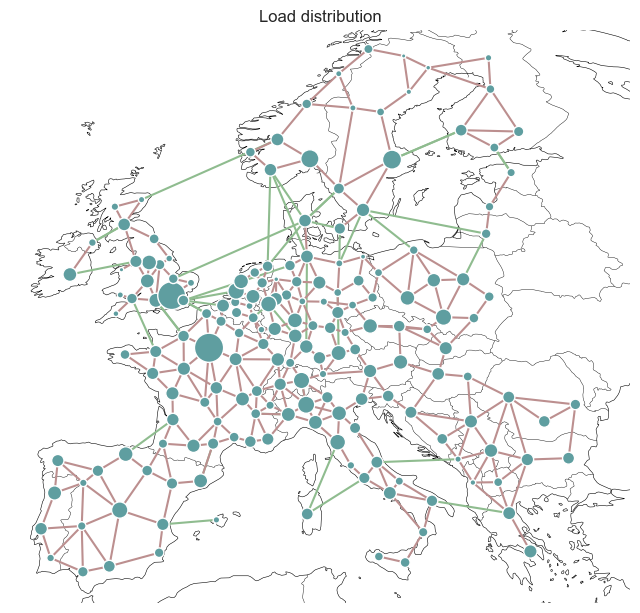

In [364]:
# network plot
m = n.copy()
m.mremove("Bus",m.buses[n.buses.x == 0].index )

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

bus_locs = pd.Index(m.buses.location.unique())
load_distribution = m.loads_t.p[bus_locs].sum()/m.loads_t.p[bus_locs].sum().max()

m.plot(bus_sizes=1*load_distribution, ax=ax, title="Load distribution", projection=ccrs.EqualEarth())
plt.show()

### Spatial distribution of market values, generation and  per technology

#### Regions

In [365]:
onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

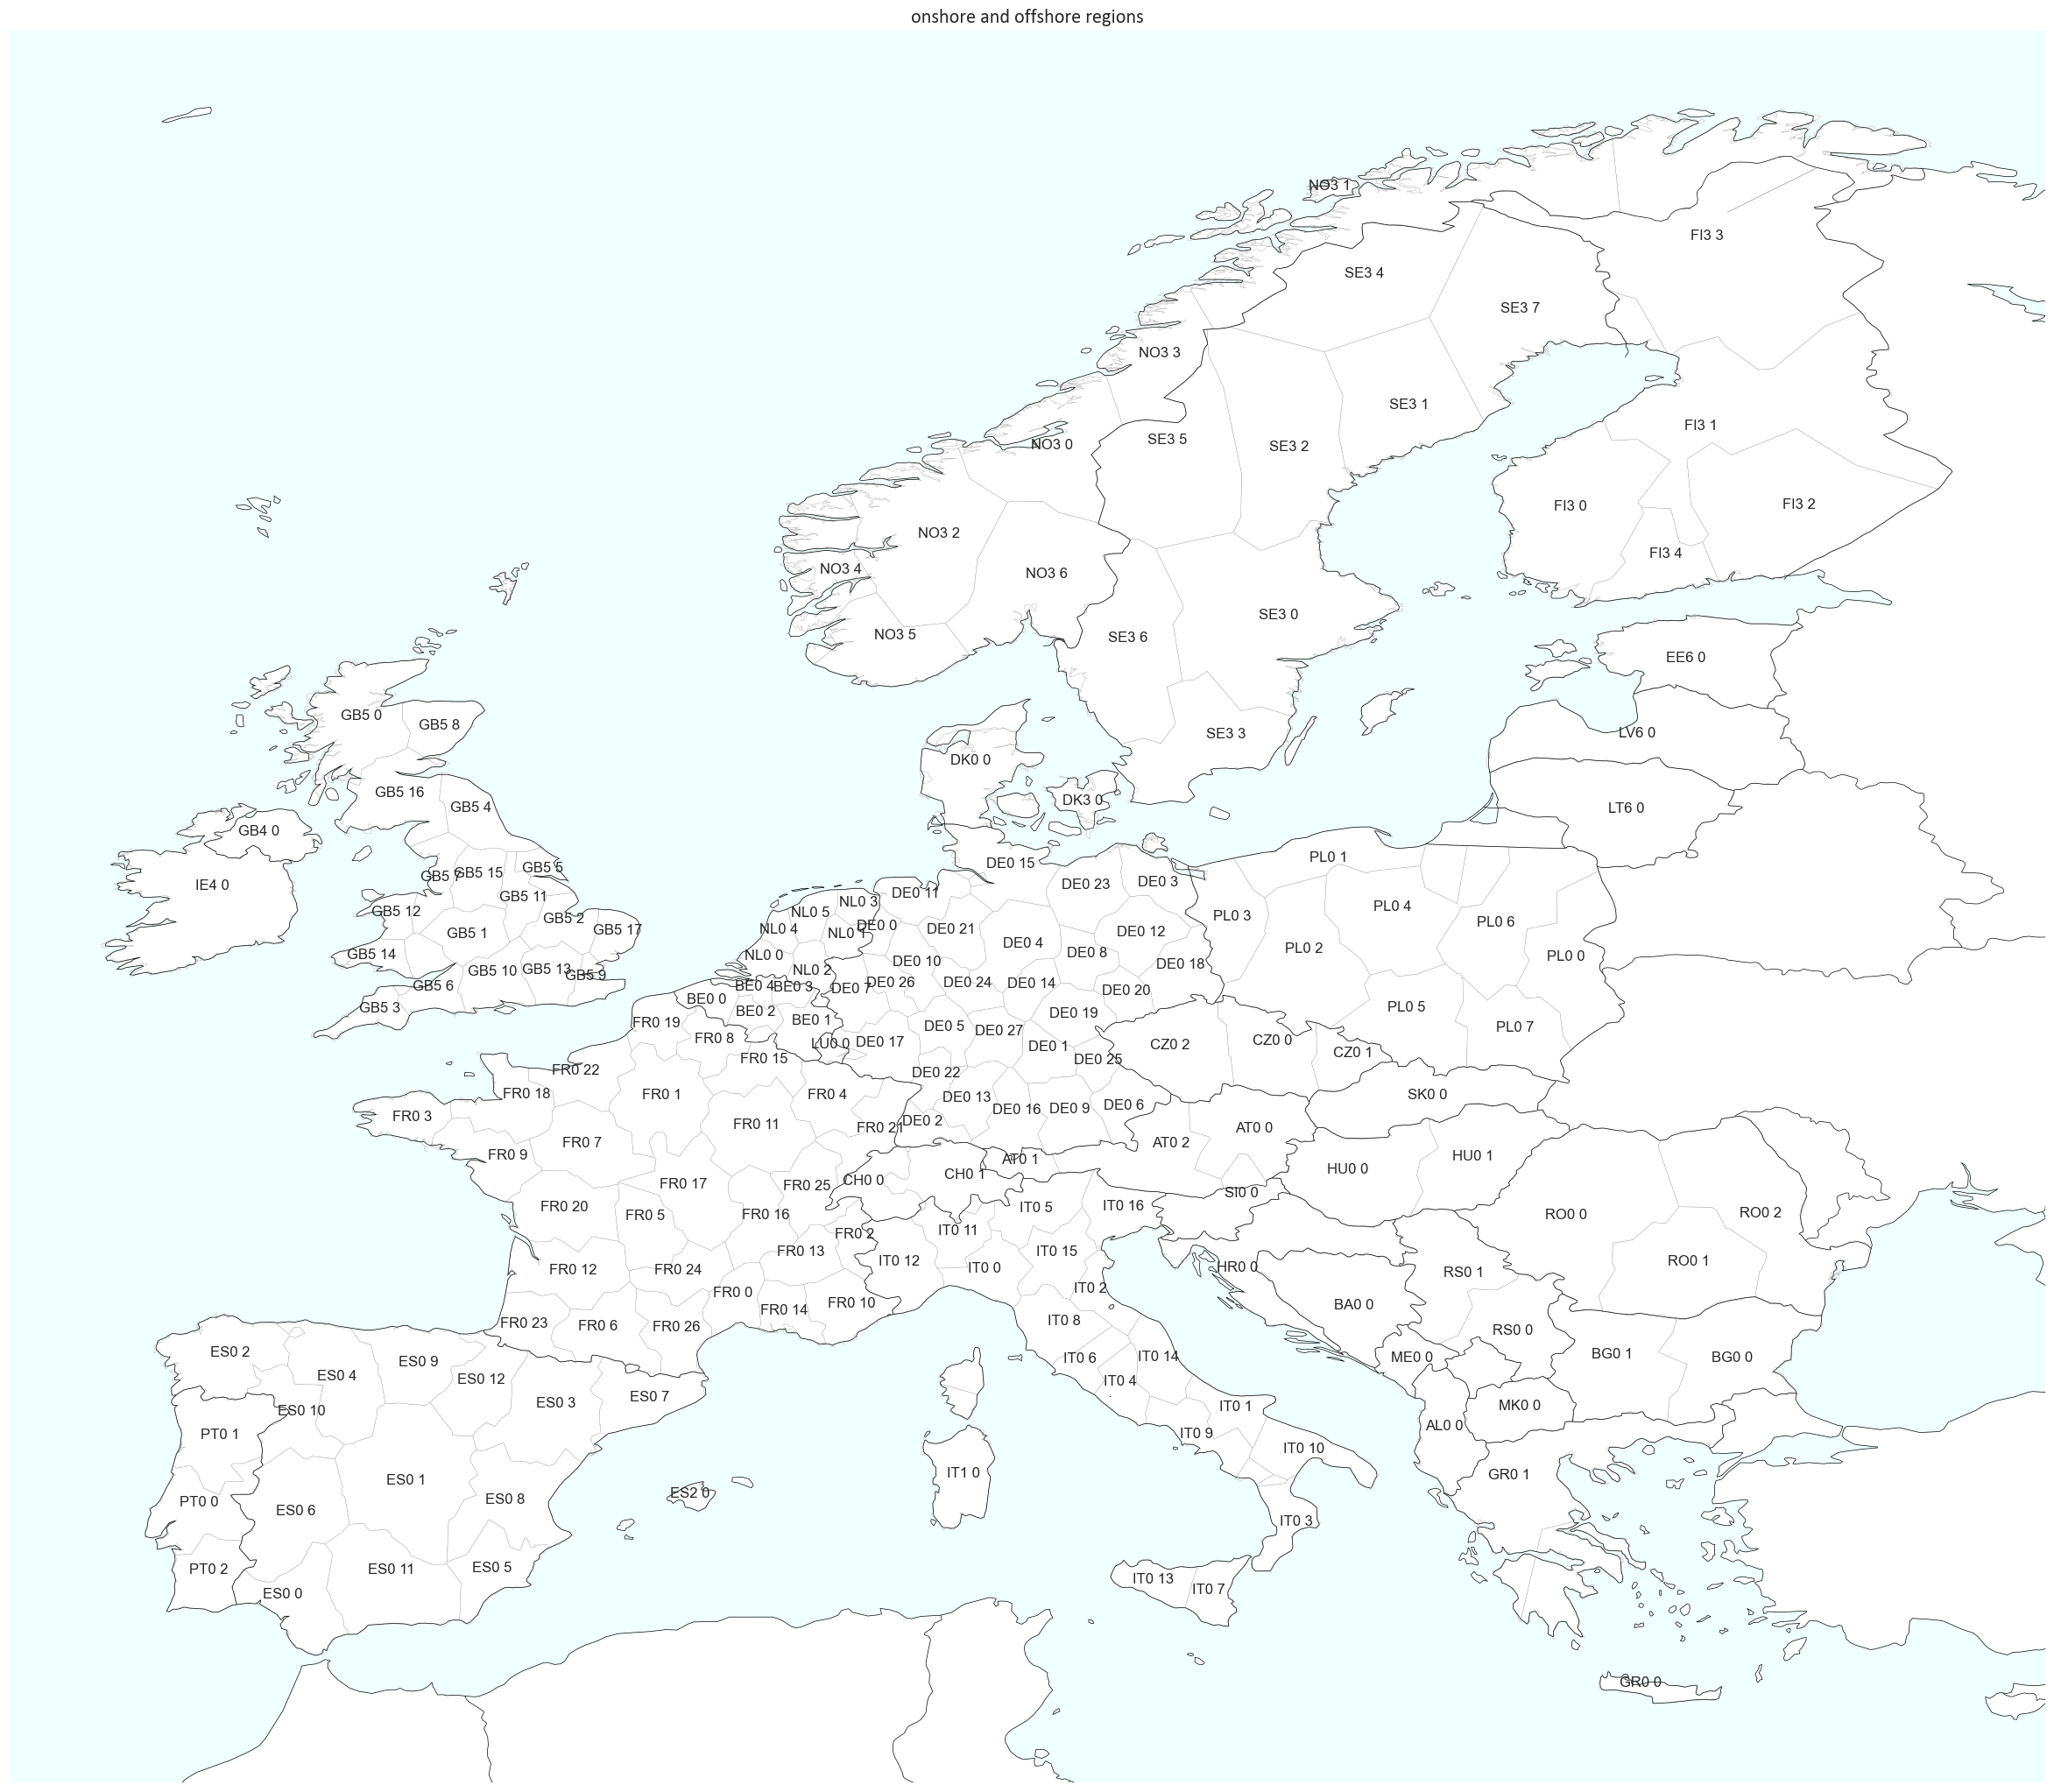

In [366]:
# onshore and offshore regions on map (overview)
fig = plt.figure(figsize=(32, 26))
crs = ccrs.PlateCarree()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title("onshore and offshore regions", fontsize=16, **font1)

onshore_regions.to_crs(crs.proj4_init).plot(ax=ax,
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

# offshore_regions.to_crs(crs.proj4_init).plot(ax=ax,
#                      linewidth=0.2,
#                      facecolor="white",
#                      edgecolor = 'grey')

for idx, row in onshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

# for idx, row in offshore_regions.iterrows():
#     plt.annotate(text=row['name'], xy=row['coords'],
#                  horizontalalignment='center')

plt.show()
# plt.close()
# fig.savefig(f"{PLOT_DIR}01_general/regions.png")

#### Market value and generation per region

In [367]:
# calc market values for generators, links and storage units
mv_regions_onshore = onshore_regions.copy()
mv_regions_offshore = offshore_regions.copy()

# function for carriers in n.generators.carrier.unique() #13
for carrier in n.generators.carrier.unique():
    mv_regions_onshore[carrier] = market_values(n, carrier)
    mv_regions_offshore[carrier] = market_values(n, carrier)
    mv_regions_onshore[f"{carrier}_gen"] = generation(n, carrier)
    mv_regions_offshore[f"{carrier}_gen"] = generation(n, carrier)

# function for carriers in n.links.carrier.unique() #53
for carrier in n.links.carrier.unique():
    mv_regions_onshore[carrier] = market_values_links(n, carrier)
    mv_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier)

# function for carriers in n.storage_units.carrier.unique() #2
for carrier in n.storage_units.carrier.unique():
    mv_regions_onshore[carrier] = market_values_storage_units(n, carrier)
    mv_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier)

# set market values to  nan where generation in corresponding region is lower than % quantile
qt = 0.2
for carrier in (n.generators.carrier.unique().tolist() + n.links.carrier.unique().tolist() + n.storage_units.carrier.unique().tolist()):
    index = mv_regions_onshore[f"{carrier}_gen"] <= np.quantile(mv_regions_onshore[f"{carrier}_gen"], qt )
    mv_regions_onshore[carrier][index] = np.nan

mv_regions_onshore.head(3)
# mv_regions_offshore.head(3)

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                         coords   name  offwind-ac  \
name                                                                 
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0  126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0         NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1         NaN   

       offwind-ac_gen     onwind    onwind_gen      solar     solar_gen  \
name                                                                      
AL0 0        9.746004        NaN  5.041607e+00  44.628736  8.232590e+06   
AT0 0             NaN  83.457109  1.013197e+07  54.679083  3.400489e+06   
AT0 1             NaN        NaN  1.159912e-01  65.745903  5.758750e+06   

             ror  ...  electricity distribution grid  \
name              ...                                  
AL0 0        NaN  ...                            NaN   
AT0 0  87.946522  ...                     117.569587   
AT0 1  97.282183  ...                            NaN   

       electricity distribution grid_gen  home battery charger  \
name                                                             
AL0 0                       1.404385e+06             78.253283   
AT0 0                       2.010033e+07             92.118676   
AT0 1                       2.514475e+06                   NaN   

       home battery charger_gen  home battery discharger  \
name                                                       
AL0 0                322.620159                86.106855   
AT0 0                305.176068               100.313215   
AT0 1                264.978903                      NaN   

       home battery discharger_gen       hydro     hydro_gen         PHS  \
name                                                                       
AL0 0                   316.101874         NaN           NaN         NaN   
AT0 0                   299.010300  146.910893  3.494307e+05         NaN   
AT0 1                   259.625248  161.367883  1.574122e+06  121.261241   

             PHS_gen  
name                  
AL0 0            NaN  
AT0 0            NaN  
AT0 1  555265.574815  

[3 rows x 139 columns]

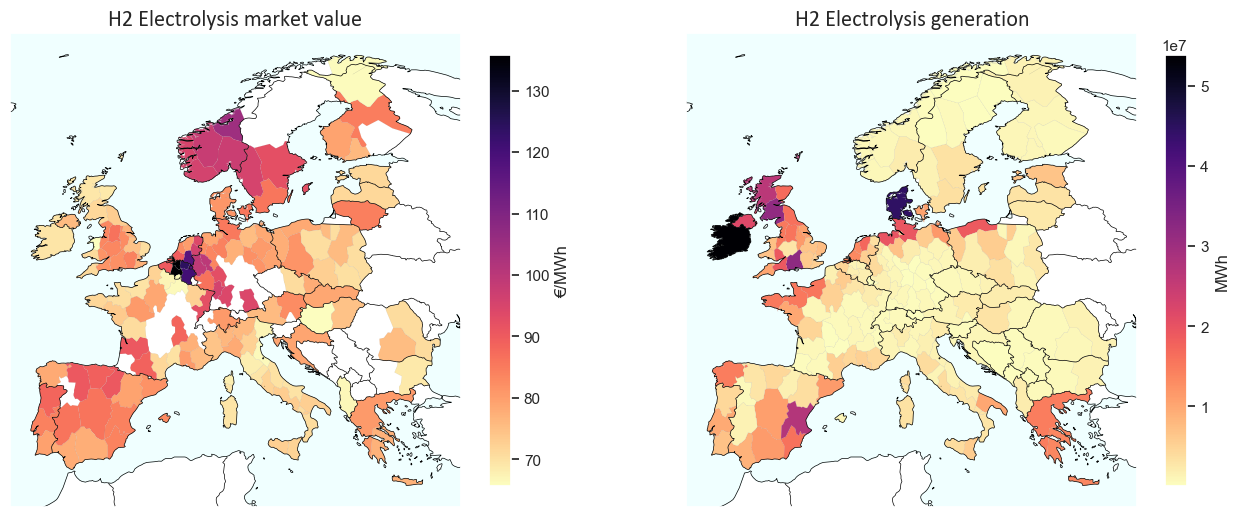

In [368]:
# carrier and generation plot
carrier = "H2 Electrolysis" # ""onwind" # "ror" # "onwind"
labels=[carrier, f"{carrier}_gen"]

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(16, 14))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    if i==0:
        title = f"{carrier} market value"
        label = "€/MWh"
    elif i==1:
        title = f"{carrier} generation"
        label = "MWh"

    mv_regions_onshore.to_crs(crs.proj4_init).plot(column=labels[i],
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':label,
                            'orientation': "vertical",
                                      'shrink' : 0.4})

    ax.set_title(title, fontsize=16, **font1)
plt.show()

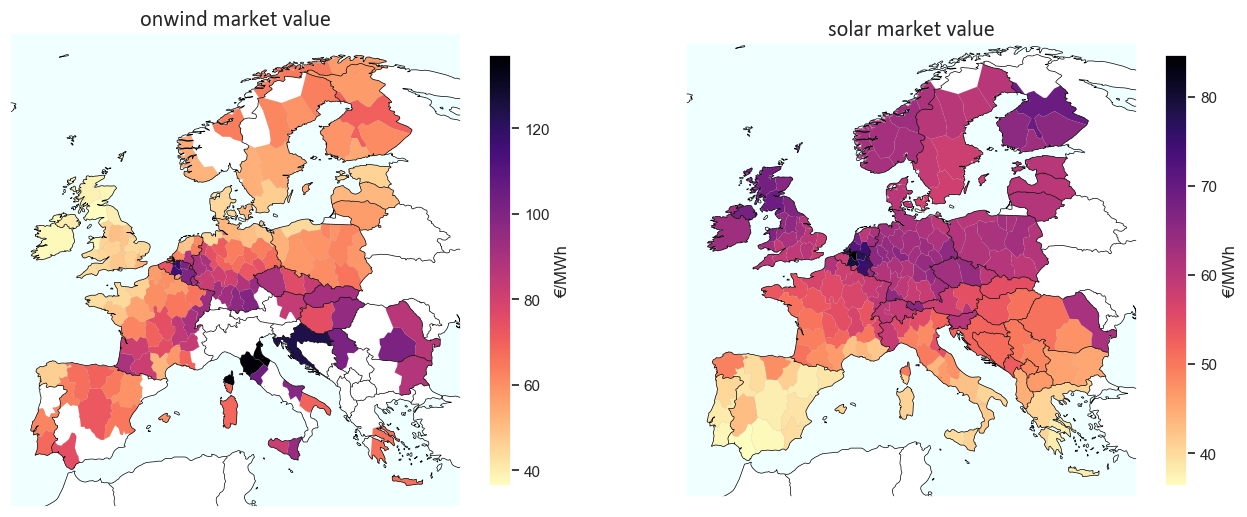

In [369]:
# compare two carriers plot
labels=["onwind", "solar"]

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(16, 14))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{labels[i]} market value", fontsize=16, **font1)

    mv_regions_onshore.to_crs(crs.proj4_init).plot(column=labels[i],
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':"€/MWh",
                            'orientation': "vertical",
                                      'shrink' : 0.4})


plt.show()

In [370]:
mv_regions_onshore[labels[0]].sort_values(ascending=False)

name
IT0 2    137.279256
IT0 8    135.522055
HR0 0    124.068663
BE0 4    119.996483
BE0 2    115.667923
            ...    
RO0 0           NaN
RS0 0           NaN
SE3 4           NaN
SE3 5           NaN
SI0 0           NaN
Name: onwind, Length: 181, dtype: float64

__Findings__
- __ror:__ highest mv in BEL, high in DEU, HRV (Croatia) and LUX; no data in NOR, little in ESP and FRA | highest production in ITA, CHE & AUT; interesting that there is no data for NOR
- __onwind:__ very high mv in a lot of parts of ITA, general higher values in eastern europe and at the coastline of the adriatic sea and lower at the atlantic coast, rest of the mediterranean Sea and baltic sea | highest production in IRL, very high in DNK and GBR; general hig at the coastline of the atlantic and low at the rest
- __solar:__ highest mv in BEL, NLD & GBR; general small range of mv troughout europe | highest production at the mediterranean Sea (ESP, GRC)
- __solar rooftop:__ highest mv in BEL NLD; general decreasing values from north to south | highest production in parts of FRA & ESP; increasing production from north to south
- __H2 Electrolysis:__ no very clear pattern; highest values in BEL, NLD and NOR; Tendency of higher values on iberian peninsula, scandinavia and inner europe
- __H2 Fuel Cell:__ highest values for central europe (DEU, BEL,NLD)
- __OCGT:__ very high values in POL, LTU, LVA & DNK; high values in DEU, iberian peninsula, UK & south of sweden
- __battery charger:__ highest values in central europe (BEL, NLD, DEU, AUT); high prices in eastern europe; moderate prices in scandinavia; low prices on iberian peninsula
- __battery discharger:__ similar pattern as battery charger with higher values in FIN and scnadinavia beeing cheaper than iberain peninsula
- __home battery charger:__ similar pattern as battery charger with a slightly higher magnitude
- __home battery discharger:__ same pattern like home battery charger with a slightly higher magnitude
- heat pumps (air-sourced/ground-sourced)
- __urban central gas boiler:__ by distance highest mv in one part of NOR; except from that very similar mv (range: 120 -150 €/MWh) in all otther regions with some exceptions
- __residential rural resistive heater:__ highes mv for ROU (Romania) & BGR (Bulgaria); general very high in the south-east of europe (GRC, SRB (Serbia), MKD (north Macedonia)
- __services rural resistive heater:__ same pattern as residential rural resistive heater with lower magnitude of mvs | "residential urban decentral resistive heater" and "services urban decentral resistive heater" are also similar
- __hydro:__ low mv in scandinavia, high mv in souther europe especially high in south-east europe (HUN, ROU, BGR); high generation in scandinavia especially south of NOR, generally higher generation furhter to the mediteraanean sea, almost nor generation in north of FRA & DEU and Benelux
- __PHS:__ no clear pattern in mv, only 72 regions across europa have values; generation is high in CHE, AUT & ESP
- __Fischer-Tropsch:__ Calculation unclear (bus1 is always EU with a constant oil lmp)
- __Sabatier:__ Calculation unclear (bus1 is always EU with a constant lmp)


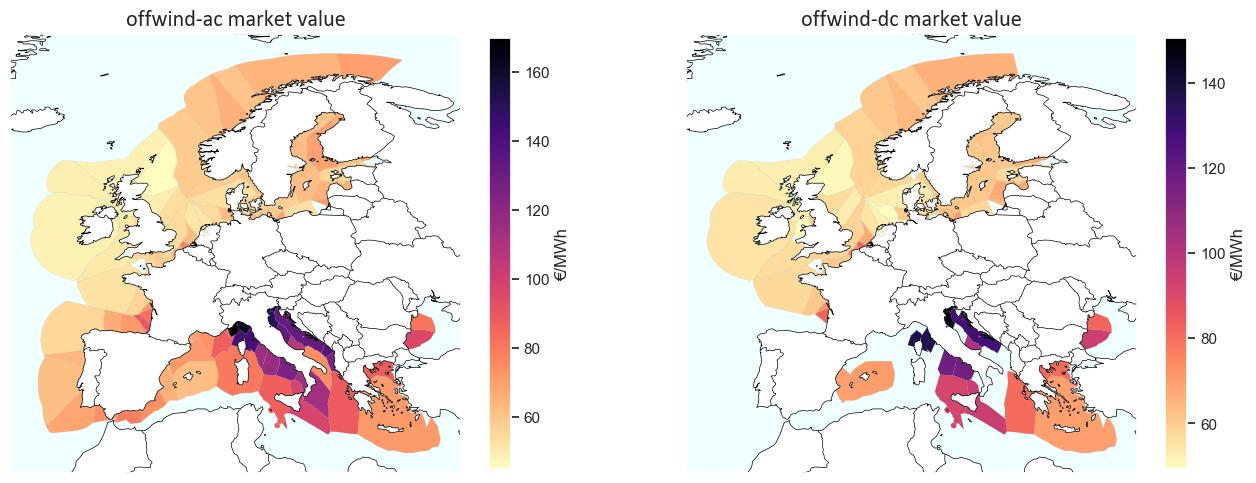

In [371]:
# offshore regions
carrier = "offwind-ac"
labels=["offwind-ac", "offwind-dc" ] # f"{carrier}_gen"

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(16, 14))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{labels[i]} market value", fontsize=16, **font1)

    mv_regions_offshore.to_crs(crs.proj4_init).plot(column=labels[i],
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':"€/MWh",
                            'orientation': "vertical",
                                      'shrink' : 0.4})
plt.show()

In [372]:
mv_regions_offshore[labels[1]].sort_values(ascending=False)

name
IT0 16    150.621108
IT0 2     147.101850
IT0 8     136.132403
HR0 0     128.425257
IT0 4     117.217259
             ...    
NO3 6            NaN
PT0 0            NaN
PT0 1            NaN
PT0 2            NaN
SI0 0            NaN
Name: offwind-dc, Length: 100, dtype: float64

__Findings__
- __offwind-ac:__ highest mv in ITA, HRO (Croatia); low around UK & at the coastlin of NOR & iside the baltic | high production at the norther coastline of FRA, BEL, NLD & DEU; southcoast of GBR and eastcoast of ROU (Romania) & BGR (Bulgaria) (Black sea)
- __offwind-dc:__ highest mv in ITA, SVN (Slowenia) & MNE (Montenegro) | high production at the norther coastline of BEL, NLD & DEU; southcoast of GBR, westcoast of FIN & GRC| mv of offwind-ac and offwinf-dc are rather similar; generation pattern is quite similar with more generation for offwind-dc

#### DIff(LMP-MV) per region

In [373]:
# get relevant carrier of bus where carrier leads to (generators & links)
carrier = "onwind"
print(f"generator: {n.buses.loc[n.generators[n.generators.carrier == carrier]['bus']]['carrier'].unique()}")
print(f"link: {n.buses.loc[n.links[n.links.carrier == carrier]['bus1']]['carrier'].unique()}")

generator: ['AC']
link: []


In [374]:
carrier_bus = 'AC' # 'AC' # 'low voltage'

mv = mv_regions_onshore[carrier]
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()

df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
lmp_regions_onshore = mv_regions_onshore[["geometry","coords","name"]].copy().rename(columns={"name": "location"})
lmp_regions_onshore = pd.merge(lmp_regions_onshore,df,on="location").set_index("location")
lmp_regions_onshore[f"diff({carrier_bus}_lmp,{carrier}_mv)"] = (lmp_regions_onshore[f"{carrier_bus}_lmp"] - mv)
lmp_regions_onshore.head(3)

geometry  \
location                                                      
AL0 0     POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0     POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1     POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                            coords      AC_lmp  \
location                                                         
AL0 0       (20.00648437943388, 41.14563914300007)   94.906301   
AT0 0     (15.700718667666258, 47.896990619088925)  109.573701   
AT0 1      (10.379200993764837, 47.18231496200006)  116.477786   

          diff(AC_lmp,onwind_mv)  
location                          
AL0 0                        NaN  
AT0 0                  26.116592  
AT0 1                        NaN

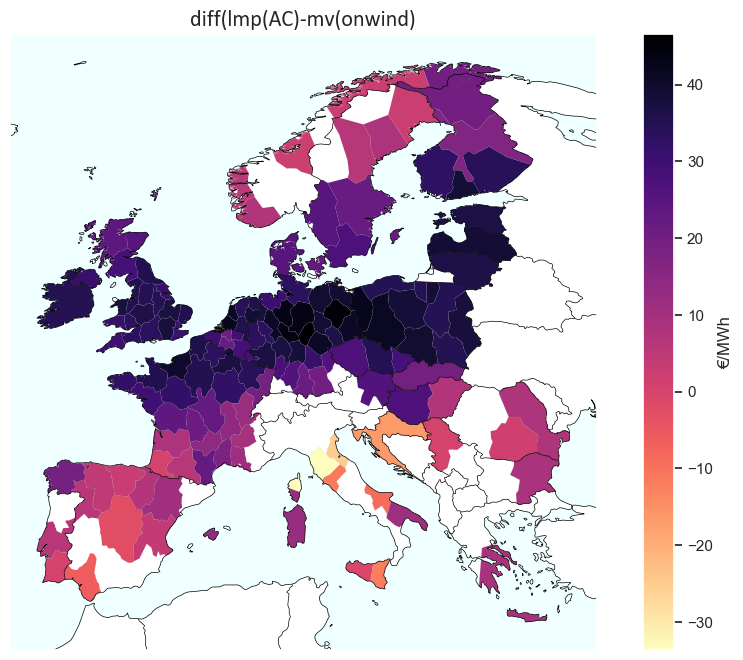

In [375]:
fig = plt.figure(figsize=(12, 8))
crs = ccrs.EqualEarth()

ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"diff(lmp({carrier_bus})-mv({carrier})", fontsize=16, **font1)

lmp_regions_onshore.to_crs(crs.proj4_init).plot(column=f"diff({carrier_bus}_lmp,{carrier}_mv)",
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

In [376]:
lmp_regions_onshore[f"diff({carrier_bus}_lmp,{carrier}_mv)"].dropna().sort_values(ascending=False)

location
DE0 14    46.587139
DE0 12    45.116026
DE0 24    43.920358
DE0 4     43.548146
DE0 21    43.217343
            ...    
IT0 6    -11.247902
IT0 7    -11.831654
HR0 0    -16.573533
IT0 2    -24.887450
IT0 8    -33.653535
Name: diff(AC_lmp,onwind_mv), Length: 144, dtype: float64

__Findings:__
- __Implications:__ high positive values mean that the lmp at the bus is on average (weighted by the production) higher than the mv of the technology which means the technology produces at times of lmps that are lower than the average (bad for the technology); high negative values mean that the technology produces disproportionately often if the lmp is relatively high (good for the technology); mv is just a weighted average of the lmp weighted by the generation, the lmp value in this case is just the average lmp over all timesteps
- __["H2","H2 Electrolysis"]:__ high diff in middle and middle-east europe (DEU, ITA, CZE, LUX, ...)
- __["battery","battery charger"]:__ very high diff in middle europe; low diff in NOR and SWE
- __["home battery","home battery charger"]:__ similar to ["battery","battery charger"]
- __["AC","solar"]:__ range(0,60); high in middle and middle-east europa low in scandinavia, UK
- __["AC","onwind"]:__ range(-30,47); high negative values in ITA
- __["AC","offwind-ac"]:__ range(-50,40); high negative values in ITA & adriatic sea, highest positive values in NLD
- __["low voltage","solar rooftop"]:__ range(-5,60); slightly negative values in GBR; verhy high values in middle and middle-east europe (DEU,ROU,HRV)

#### Market values per country

In [377]:
# geopandas country data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.drop(["pop_est","gdp_md_est"], axis=1)
# Remove French Guiana from France.
shape = world[world['name'] == 'France']['geometry'].all()
fr_df = pd.Series(['France', 'France'], name='country')
fr_df = gpd.GeoDataFrame(fr_df, geometry=[shape[1], shape[2]])
fr_df = fr_df.dissolve(by='country')
world.geometry[world['name'] == 'France'] = fr_df['geometry'].values
# Remove Svalbard
shape = world[world['name'] == 'Norway']['geometry'].all()
no_df = pd.Series(['Norway'], name='country')
no_df = gpd.GeoDataFrame(no_df, geometry=[shape[1]])
no_df = no_df.dissolve(by='country')
world.geometry[world['name'] == 'Norway'] = no_df['geometry'].values

In [378]:
# convert country codes and map
mv_country_onshore = mv_regions_onshore.drop(["geometry","coords"], axis=1)
mv_country_onshore["country"] = mv_country_onshore.index.str[:2]
mv_country_onshore = mv_country_onshore.groupby(by="country").mean()
mv_country_onshore["iso_a3"] = pd.Index([convert_ISO_3166_2_to_1[cc] for cc in mv_country_onshore.index])
mv_country_onshore=pd.merge(world, mv_country_onshore,on='iso_a3')

mv_country_onshore['coords'] = mv_country_onshore['geometry'].apply(lambda x: x.representative_point().coords[:])
mv_country_onshore['coords'] = [coords[0] for coords in mv_country_onshore['coords']]
mv_country_onshore.head()

continent     name iso_a3  \
0    Europe   Norway    NOR   
1    Europe   France    FRA   
2    Europe   Sweden    SWE   
3    Europe   Poland    POL   
4    Europe  Austria    AUT   

                                            geometry  offwind-ac  \
0  POLYGON ((31.10104 69.55810, 29.39955 69.15692...   60.821353   
1  MULTIPOLYGON (((9.39000 43.00998, 9.56002 42.1...   69.024474   
2  POLYGON ((11.02737 58.85615, 11.46827 59.43239...   60.779603   
3  POLYGON ((23.48413 53.91250, 23.52754 53.47012...   61.489763   
4  POLYGON ((16.97967 48.12350, 16.90375 47.71487...         NaN   

   offwind-ac_gen     onwind    onwind_gen      solar     solar_gen  ...  \
0       92.139947  58.742397  2.028227e+06  62.437041  9.832202e+01  ...   
1   288410.894481  66.778084  8.784395e+06  52.791854  4.748776e+06  ...   
2      115.679558  56.442303  4.844137e+06  59.351173  1.739875e+06  ...   
3      113.739375  57.741911  1.419539e+07  61.004764  4.707282e+06  ...   
4             NaN  83.457109  3.377324e+06  59.549591  7.584998e+06  ...   

   electricity distribution grid_gen  home battery charger  \
0                       6.503212e+06             64.426647   
1                       8.760138e+06             74.095346   
2                       7.150847e+06             64.370470   
3                       1.209326e+07             80.352057   
4                       1.218403e+07             90.863568   

   home battery charger_gen  home battery discharger  \
0                359.148821                64.978916   
1                335.223260                82.742675   
2                362.887237                67.379614   
3                346.205829                88.170438   
4                290.522851                98.904748   

   home battery discharger_gen       hydro     hydro_gen         PHS  \
0                   351.892593   66.636340  5.412610e+06   79.109120   
1                   328.450399  133.649293  9.645408e+05  123.303587   
2                   355.555448   95.380346  1.945046e+06  126.154068   
3                   339.211073  118.129879  1.153478e+05  112.968907   
4                   284.653088  150.951966  2.291905e+06  150.543639   

         PHS_gen                                   coords  
0   38596.159262   (12.220765820415032, 64.6365330064395)  
1  493214.357299  (2.099228142939435, 46.895070705750044)  
2   73760.686407  (14.786243427055595, 62.27488129337668)  
3   75129.698671  (19.076267455907114, 51.88441732442235)  
4  891037.443123  (14.953149823900707, 47.91918132180231)  

[5 rows x 141 columns]

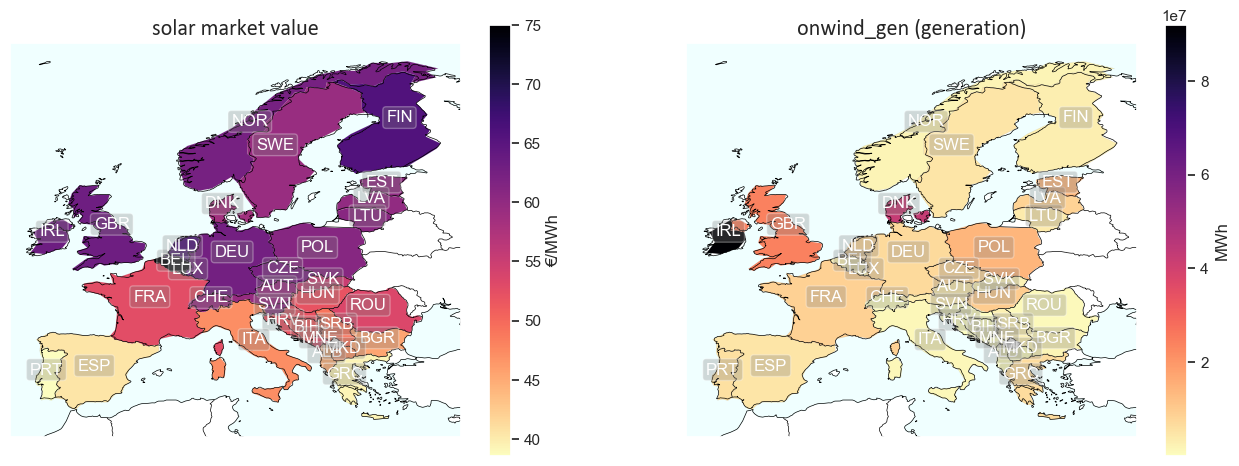

In [379]:
# compare two carriers
carriers=["solar", "onwind_gen"]

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 14))
crs = ccrs.PlateCarree()

for i, ax in enumerate(axs):

    if i == 0:
        title=f"{carriers[i]} market value"
        label="€/MWh"
    else:
        title=f"{carriers[i]} (generation)"
        label="MWh"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(title, fontsize=16, **font1)

    mv_country_onshore.to_crs(crs.proj4_init).plot(column=carriers[i],
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label': label,'orientation': "vertical",'shrink' : 0.4}
                                                   )

    for idx, row in mv_country_onshore.iterrows():
        ax.annotate(text=row['iso_a3'], xy=row['coords'], color='white',
                     bbox=dict(boxstyle='round,pad=0.2', fc='grey', alpha=0.3),
                     horizontalalignment='center')

plt.show()

In [380]:
# carriers for which market_values function does not work
# -> there are 24 carrier which are not a generators but attached to a bus; from the generators only 2 are also attached to buses {'gas', 'oil'}
# all renewables are produced at generators and are not directly attached to a bus; the generator is attached to the bus (thats also why they do not have lmps)
# set(n.buses.carrier.tolist()) - set(n.generators.carrier.tolist()) # 24

In [381]:
# fig.savefig(f"{PLOT_DIR}mv_country.png")

In [382]:
mv_country_onshore.isna().sum()

continent      0
name           0
iso_a3         0
geometry       0
offwind-ac     9
              ..
hydro          8
hydro_gen      8
PHS           12
PHS_gen       12
coords         0
Length: 141, dtype: int64

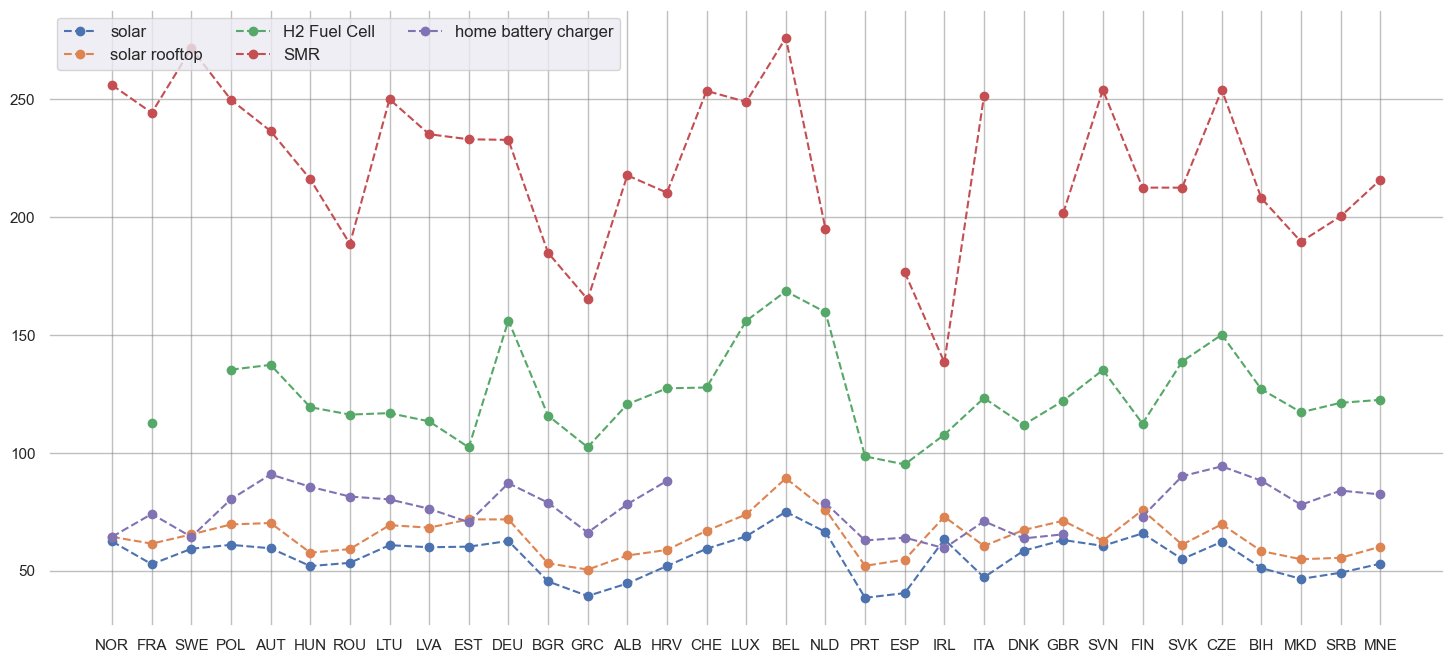

In [383]:
# market value of selected carriers per region
carriers_h = ['OCGT','urban central gas CHP','SMR']
carriers_l = ['H2 Electrolysis','onwind', 'solar','ror']
carriers_comp = ['solar', 'solar rooftop', 'H2 Fuel Cell', 'SMR', 'home battery charger']

ax = mv_country_onshore[carriers_comp].plot(figsize=(18,8), style="--", marker='o', grid=True)
plt.legend(loc='upper left', ncol=3, prop={'size': 12})
ax.set_xticks(range(len(mv_country_onshore)))
ax.set_facecolor('white')
ax.set_axisbelow(True)
plt.grid(color='grey', alpha=0.5)
ticks = ax.set_xticklabels(labels = [item for item in mv_country_onshore.iso_a3.tolist()], rotation=0)
# Set the background color to white

### Temporal distribution of market values (Seasonality)

In [384]:
#TODO: plots to show the seasonality (winter, summer) (quarters)

### Spatial and temporal distribution of prices:

- electricity
- heat (various subcategories)
- hydrogen

#### Lmps per region (spatial distribution)

In [385]:
carrier_bus = "AC"
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
lmp_regions_onshore = mv_regions_onshore[["geometry","coords","name"]].copy().rename(columns={"name": "location"})
lmp_regions_onshore = pd.merge(lmp_regions_onshore,df,on="location").set_index("location")
lmp_regions_onshore.head(3)

geometry  \
location                                                      
AL0 0     POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0     POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1     POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                            coords      AC_lmp  
location                                                        
AL0 0       (20.00648437943388, 41.14563914300007)   94.906301  
AT0 0     (15.700718667666258, 47.896990619088925)  109.573701  
AT0 1      (10.379200993764837, 47.18231496200006)  116.477786

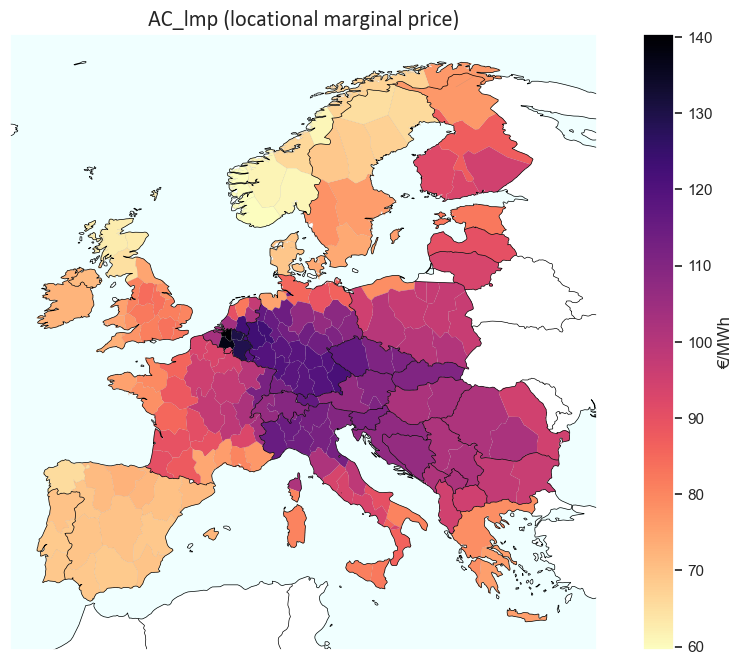

In [386]:
fig = plt.figure(figsize=(12, 8))
crs = ccrs.EqualEarth()

ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier_bus}_lmp (locational marginal price)", fontsize=16, **font1)

lmp_regions_onshore.to_crs(crs.proj4_init).plot(column=f"{carrier_bus}_lmp",
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

#### Nodal Prices for every time step (sum) - heatmap (temporal distribution)

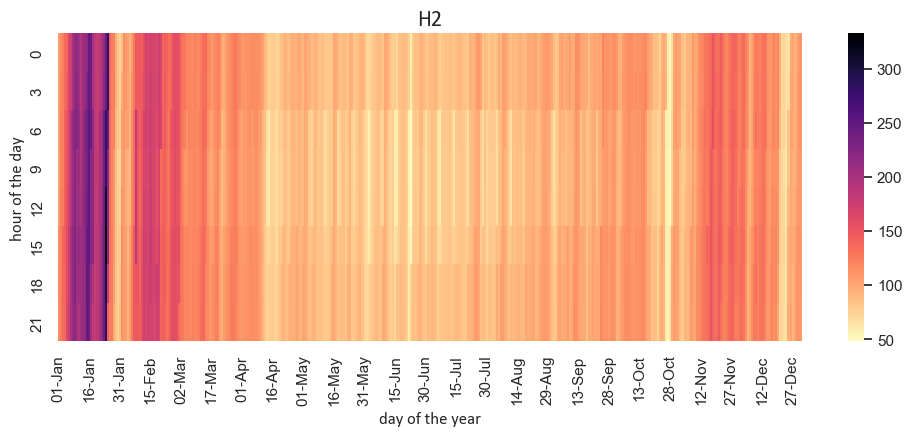

In [387]:
carrier = "H2" # "battery" # "Li ion" # H2, services rural heat, low voltage (no values for VRE as they do not have their own buses)

# change to mean for investigating in mean (unit: €/MWh)
df = pd.DataFrame(n.buses_t.marginal_price[n.buses[n.buses.carrier==carrier].index].mean(axis=1))

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 4))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15)
plt.title(str(carrier), fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

__Findings:__
- __H2:__ no clear pattern during the day; seasonal pattern as higher lmps in the winter with increasing lpms during winter from Nov-Jan; rather constant during summer
- __battery:__ cheaper from hour 6 to 12; higher lmps in winter (Nov-Mar) with highest in Jan; rather constant during summer with some more expensive days
- __Li ion:__ same as battery (also same magnitude)
- __low voltage:__ similar to battery with a hgher magnitude in range(0,700)
- __services rural heat:__ range(0,900); most expensive in hours 3,6 and 18; very low values during warmer months (Apr-Oct); highest lmps in Jan
- __urban central heat:__ range(0,130); clear daily pattern: lower in night (hours: 21,0) and during midday (hours: 9,12) and higher in the morning and afternoon; lower in warmer months (Apr-Sep) and higest lmps in winter (Nov-Mar)

##### Case Study: H2 Comparison
comparison of wind driven baltic sea regions and sun driven Mediterranean Sea regions

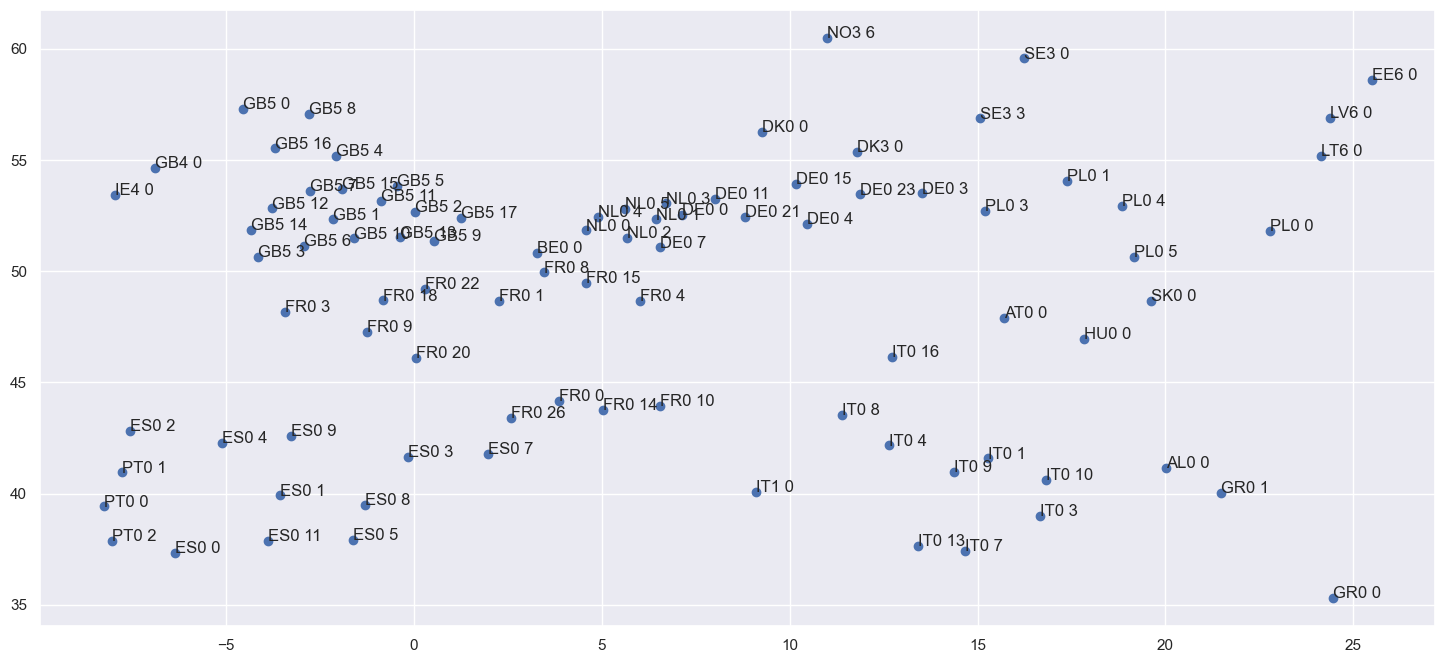

In [388]:
help = mv_regions_onshore[mv_regions_onshore["H2 Electrolysis_gen"] > np.quantile(mv_regions_onshore["H2 Electrolysis_gen"], 0.5)][["name", "coords"]]

names = help.name.tolist()

help['x'] = [x[0] for x in help.coords]
help['y'] = [x[1] for x in help.coords]
x = help.x
y = help.y

names = help.name.tolist()

fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(x, y)

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]))

In [389]:
north = help[help['y'] >= 45].index
south = help[help['y'] < 45].index

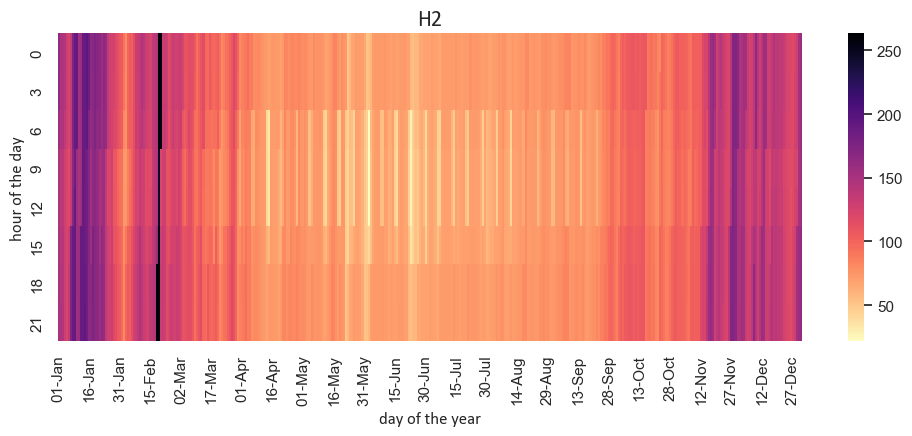

In [390]:
carrier = "H2" # "battery" # "Li ion" # H2, services rural heat, low voltage (no values for VRE as they do not have their own buses)
bus_index = south

buses = n.buses[n.buses.carrier==carrier].index
help_df = pd.DataFrame(n.buses.loc[buses]["location"])
help_df["bus"] = help_df.index
help_df.set_index('location', inplace=True)

# change to mean for investigating in mean (unit: €/MWh)
df = pd.DataFrame(n.buses_t.marginal_price[pd.Index(help_df.loc[bus_index].bus)].mean(axis=1))

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 4))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15)
plt.title(str(carrier), fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

#### Seasonal Pattern of nodal Prices (temporal distribution)

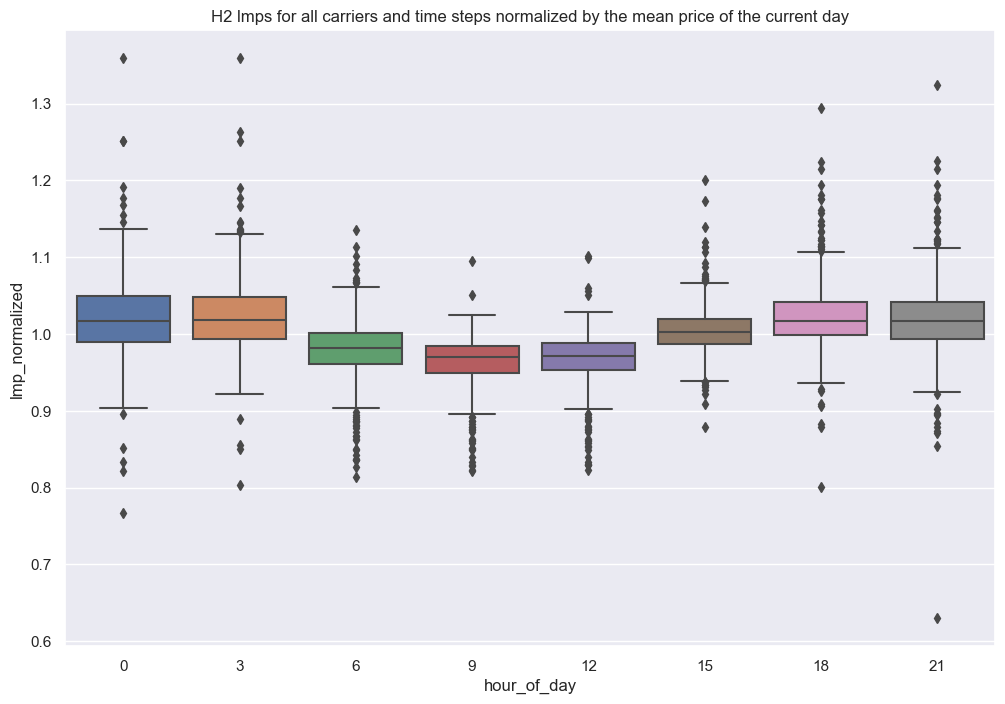

In [391]:
# # Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the current day
carrier_bus = "H2" #carriers_buses
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index]

plt.figure(figsize=(12, 8))
df3 = pd.DataFrame(lmps.mean(axis=1))
df3.columns = ["lmp"]
df3["lmp_normalized"] = np.nan

for snap in df3.index:
    df3.loc[snap, "lmp_normalized"] = df3.loc[snap, "lmp"] / df3[df3.index.date == snap.date()].lmp.mean()

df3["hour_of_day"] = df3.index.hour
sns.boxplot(data=df3, y="lmp_normalized", x="hour_of_day")
plt.title(f"{carrier_bus} lmps for all carriers and time steps normalized by the mean price of the current day")
plt.show()

#### GIF

##### days

carrier = "onwind"
df = market_values_by_time_index(n, days, carrier)
df = df.apply(pd.to_numeric)

for day in days:

    fig = plt.figure(figsize=(10, 8))

    crs = ccrs.AlbersEqualArea()
    ax = plt.axes(projection=ccrs.AlbersEqualArea())
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{carrier} market value @ {day.date()} in €/MWh", fontsize=22, **font1)

    df2 = onshore_regions.copy()
    df2[carrier] = df.loc[day]

    df2.to_crs(crs.proj4_init).plot(column=carrier,
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'orientation': "vertical",
                            'shrink' : 1}
                                    )
    fig.tight_layout()
    fig.savefig(f"{PLOT_DIR}\GIF\onwind_mv\days\mv_onwind_{day.date()}.png")
    plt.close()

##### weeks

carrier = "onwind"
weeks = np.arange(1,53,1)

for week in weeks:

    fig = plt.figure(figsize=(10, 8))

    crs = ccrs.AlbersEqualArea()
    ax = plt.axes(projection=ccrs.AlbersEqualArea())
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    if week < 10:
        week_title = f"0{week}"
    else:
        week_title = week

    ax.set_title(f"{carrier} market value @ week {week_title} (from {n.generators_t.p[n.generators_t.p.index.week == week].index[0].date().strftime('%b %d')}) in €/MWh", fontsize=18, **font1)

    # calc mv
    gen = n.generators_t.p.loc[n.generators_t.p.index.week == week, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)
    lmp = n.buses_t.marginal_price.loc[n.buses_t.marginal_price.index.week == week, gen.columns]
    mv = (gen * lmp).sum() / gen.sum()
    mv.index = mv.index.map(n.buses.location)
    df = onshore_regions.copy()
    df[carrier] = mv

    df.to_crs(crs.proj4_init).plot(column=carrier,
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'orientation': "vertical",
                            'shrink' : 1}
                                    )
    fig.tight_layout()
    fig.savefig(f"{PLOT_DIR}\GIF\onwind_mv\weeks\mv_onwind_week{week}.png")
    plt.close()

### Time series analysis

- when do different technologies produce?
- when are their revenues created? (nodal price * production)
- what are the prices when they produce?


#### Technology Operation and Revenue by Price band

##### Energy conversion technologies production and revenue by output technology price band

In [392]:
# plot percentage of production per price band and percentage of revenue per price band
carriers_gen = ["onwind", "solar", "ror", "offwind-ac", 'urban central solar thermal']
carriers_link = ["OCGT", "H2 Electrolysis", "H2 Fuel Cell", "urban central gas CHP", "SMR", "SMR CC","electricity distribution grid", 'urban central air heat pump', 'urban central water tanks discharger','urban central resistive heater', 'urban central gas boiler', 'battery discharger']
carriers_labels = (carriers_gen + carriers_link)
price_bands = [-np.inf, 0, 5, 50, 100, 200, 1000, np.inf]
price_bands_labels = ["< 0","0 - 5", "5 - 50", "50 - 100", "100 - 200", "200 - 1000", "> 1000"]
res_prod = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)
res_rev = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)

In [393]:
for carrier in carriers_gen:
    gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

for carrier in carriers_link:
    # prices of the generated energy
    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

In [394]:
# plot shows price bands for different technologies (prices of the output technology is used)
# onwind is categorised by the price of electricity and H2 Electrolysis by the price of H2

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Technology operation and revenue by price band')

ax0 = res_prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=45)

ax1 = res_rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=45)

fig.tight_layout()
plt.close()

__Findings:__
- Implications:
- __onwind:__ 20 % energy delivered in band 1 but almost no impact on revenue; price bands 1-3 account for over 90% of delivered energy but only for 70% of the revenue stream; price bands 4 & 5 account for less than 10 % of delivered energy but for 30 % of revenues
- __solar:__ similar to onwind
- __ror:__ General higher production in more expensive price bands 1-3 account for 70 % of production but only for 40 % of revenue
- __H2 Electrolysis:__ production mostly within price bands 3 & 4 and revenue almost only in price band 3 & 4

##### Energy conversion technologies production and revenue by input technology price band (links)

In [395]:
carriers = car_link_mix.copy()
carriers.extend(["H2 liquefaction", "electricity distribution grid", "urban central water tanks charger"])

res_prod2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers)
res_rev2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers)

In [396]:
for carrier in carriers:
# prices of the consumed energy
    con = n.links_t.p0.loc[:, n.links.carrier == carrier]
    transform_columns = n.links_t.p0.loc[:, n.links.carrier == carrier].columns.map(n.links.bus1)
    con.columns = con.columns.map(n.links.bus0)
    lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
    cost = con * lmp_con

    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp_gen = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp_gen

    for i in range(len(price_bands)-1):
        lmp_cat1 = lmp_con.mask((lmp_con >= price_bands[i]) & (lmp_con < price_bands[i+1]), "hit")
        # pay attention to indices (if something went wrong then probably here)
        lmp_cat1.columns = transform_columns
        res_prod2.loc[str(i), carrier] = gen[lmp_cat1 == "hit"].sum().sum() / gen.sum().sum()
        res_rev2.loc[str(i), carrier] = rev[lmp_cat1 == "hit"].sum().sum() / rev.sum().sum()

In [397]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

fig.suptitle('Energy conversion technologies production and revenue by input technology price band (links) ')

ax0 = res_prod2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=45)

ax1 = res_rev2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=45)

fig.tight_layout()
plt.close()

__Findings:__
- ...

##### Electricity (AC)

In [398]:
# check which technologies produce and consume which specific type of energy
bus_carrier = "urban central heat" #"services urban decentral heat" # "urban central heat" # "services rural heat" # "battery"# "H2 liquid" #"H2" # "low voltage" # "AC"
# buses that have the specifiy type of energy as their carrier
buses = n.buses[n.buses.carrier == bus_carrier].index
# generators whch are at the bus
print(f'generators (producer): {n.generators[n.generators.bus.isin(buses)].carrier.unique().tolist()} \n')
print(f'links (consumer):  {n.links[n.links.bus0.isin(buses)].carrier.unique()} \n')
print(f'links (producer): {n.links[n.links.bus1.isin(buses)].carrier.unique()}')

generators (producer): ['urban central solar thermal'] 

links (consumer):  ['urban central water tanks charger'] 

links (producer): ['urban central air heat pump' 'urban central water tanks discharger'
 'urban central resistive heater' 'urban central gas boiler']


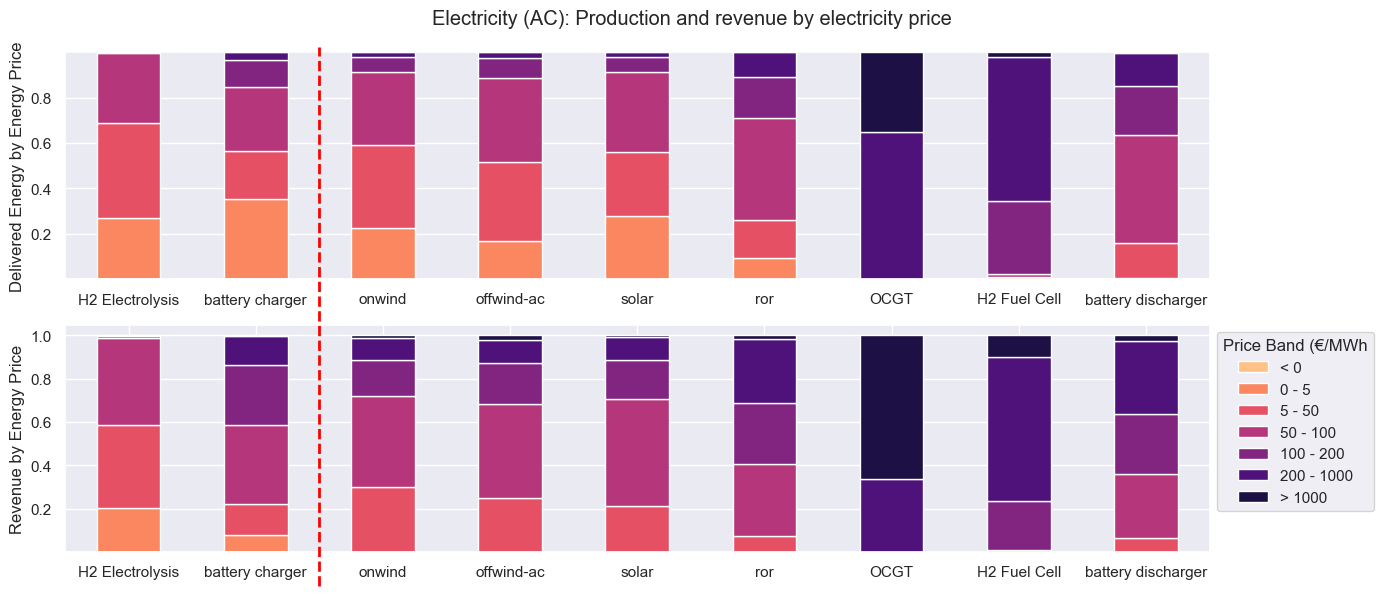

In [399]:
# is it relevant which type of electricity is compared? AC, low voltage,

el_cons = ['H2 Electrolysis', 'battery charger' ]
el_prods_gens = ['onwind', 'offwind-ac', 'solar', 'ror']
el_prods_links = ['OCGT', 'H2 Fuel Cell', 'battery discharger']
carriers = el_cons + el_prods_gens + el_prods_links

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Electricity (AC): Production and revenue by electricity price')

prod = pd.concat([res_prod2[el_cons], res_prod[el_prods_gens + el_prods_links]])
rev = pd.concat([res_rev2[el_cons], res_rev[el_prods_gens+el_prods_links]])

ax0 = prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
# ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=0)

ax1 = rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[1])
ax1.set_ylabel("Revenue by Energy Price")
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels , bbox_to_anchor=(1, 1))
# ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=0)

ax1.axvline(x=len(el_cons)-0.5,ymin=-0.15,ymax=2.22,c="red",linewidth=2,linestyle="--", zorder=3, clip_on=False, label="seperator")

fig.tight_layout()

##### Hydrogen (not liquified)

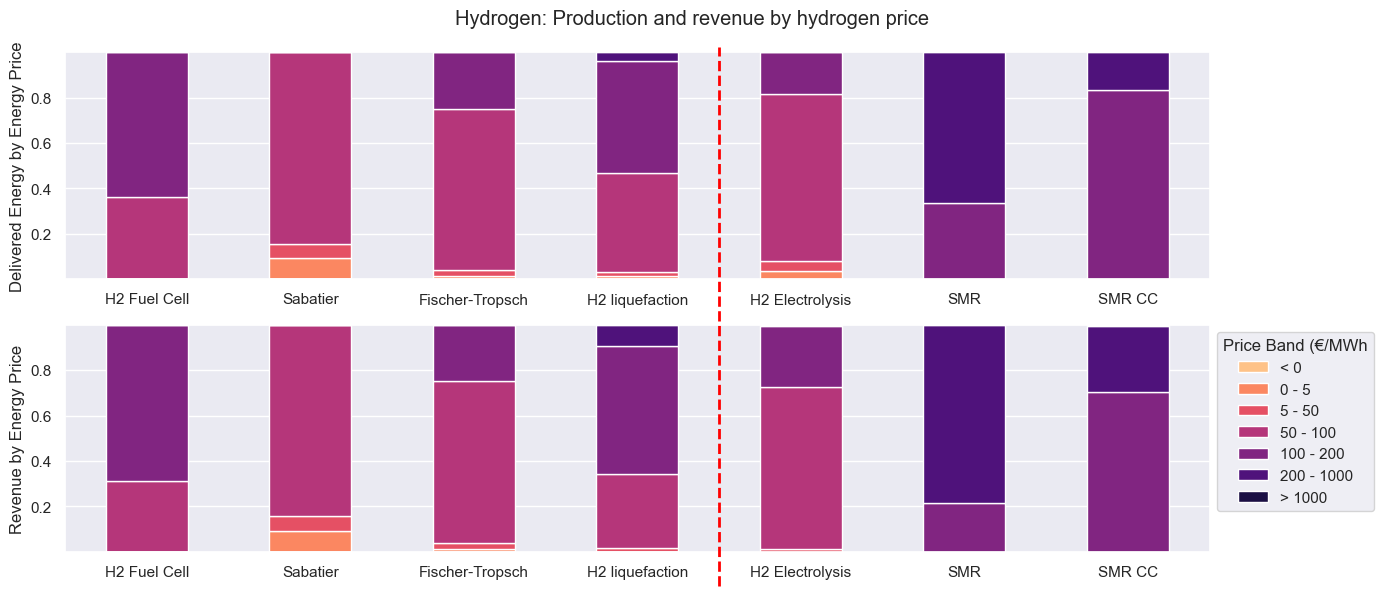

In [400]:
h2_cons = ['H2 Fuel Cell', 'Sabatier', 'Fischer-Tropsch', 'H2 liquefaction']
h2_prods = ['H2 Electrolysis', 'SMR', 'SMR CC']
carriers = h2_cons + h2_prods

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Hydrogen: Production and revenue by hydrogen price')

prod = pd.concat([res_prod2[h2_cons], res_prod[h2_prods]])
rev = pd.concat([res_rev2[h2_cons], res_rev[h2_prods]])

ax0 = prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
# ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=0)

ax1 = rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[1])
ax1.set_ylabel("Revenue by Energy Price")
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels , bbox_to_anchor=(1, 1))
# ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=0)

ax1.axvline(x=len(h2_cons)-0.5,ymin=-0.15,ymax=2.22,c="red",linewidth=2,linestyle="--", zorder=3, clip_on=False, label="seperator")

fig.tight_layout()

##### Heat (urban central heat)

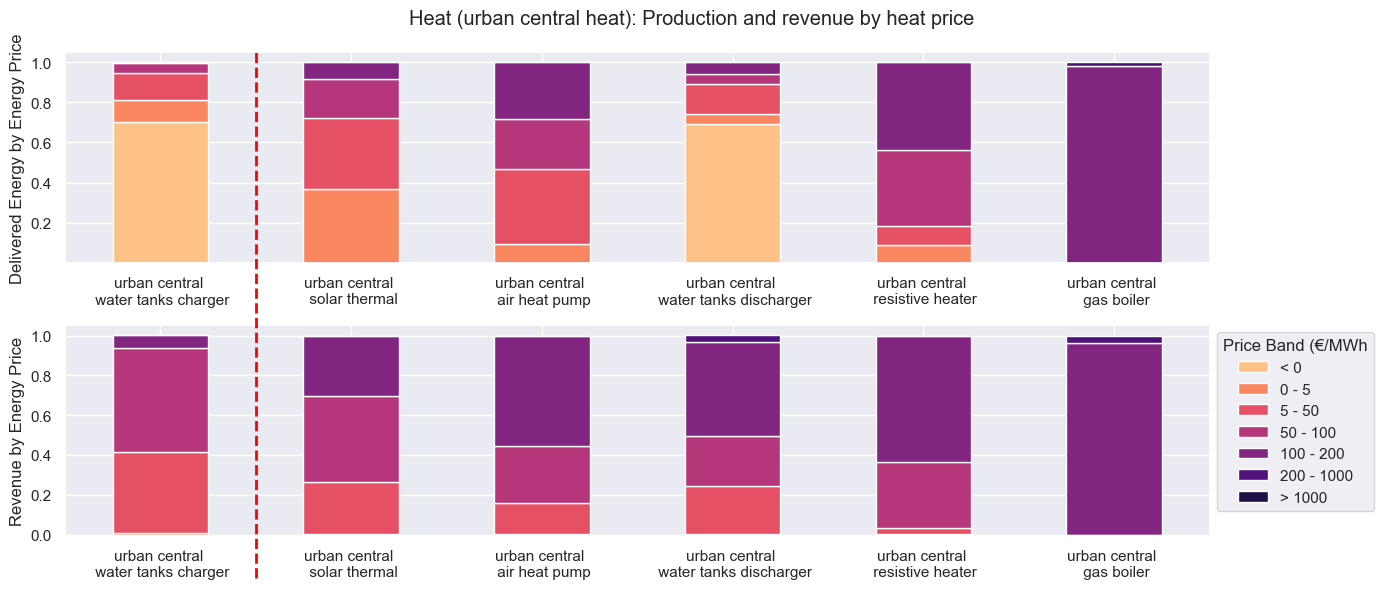

In [401]:
# urban central heat

he_cons = ['urban central water tanks charger' ]
he_prods_gens = ['urban central solar thermal']
he_prods_links = ['urban central air heat pump', 'urban central water tanks discharger','urban central resistive heater', 'urban central gas boiler']
carriers = he_cons + he_prods_gens + he_prods_links
# make newline after 2 words of label
labels = [' '.join(carrier.split(' ')[:2] + ["\n"] + carrier.split(' ')[2:]) for carrier in carriers]

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Heat (urban central heat): Production and revenue by heat price')

prod = pd.concat([res_prod2[he_cons], res_prod[he_prods_gens+he_prods_links]])
rev = pd.concat([res_rev2[he_cons], res_rev[he_prods_gens+he_prods_links]])

ax0 = prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
# ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers)), labels=labels, rotation=0)

ax1 = rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 7), ax=axes[1])
ax1.set_ylabel("Revenue by Energy Price")
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels , bbox_to_anchor=(1, 1))
# ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers)), labels=labels , rotation=0)

ax1.axvline(x=len(he_cons)-0.5,ymin=-0.2,ymax=2.3,c="red",linewidth=2,linestyle="--", zorder=3, clip_on=False, label="seperator")

fig.tight_layout()

#### Fourier Transform

- problem1: you only have data for one year
- problem2: data is in 3h steps
-
without further adjustments:
- daily pattern would be after 8 snaps (8*3=24) as we have a 3-hourly dataset
- weekly after 56 snaps
- monthly pattern after 240
- yearly pattern cannot be observed as we only have data for one year
with adjustments
- daily: 24
- weekly: 168
- monthly: 5040

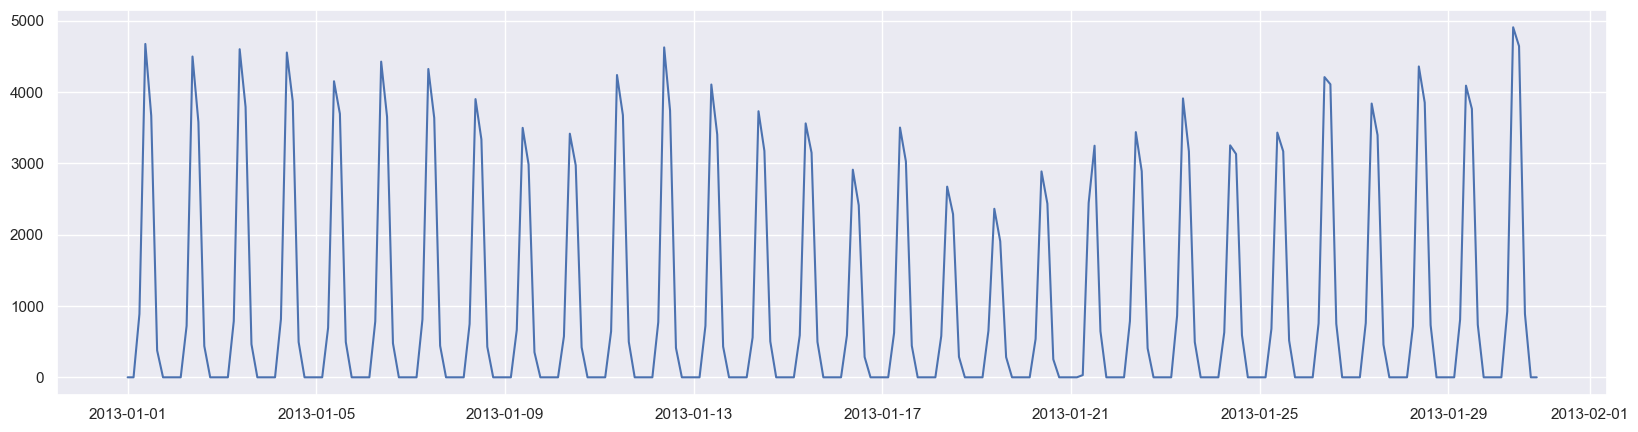

In [402]:
carrier = "solar"
gens = n.generators_t.p[n.generators[n.generators.carrier == carrier].index].mean(axis=1)
plt.plot(gens[:8*30])
plt.show()

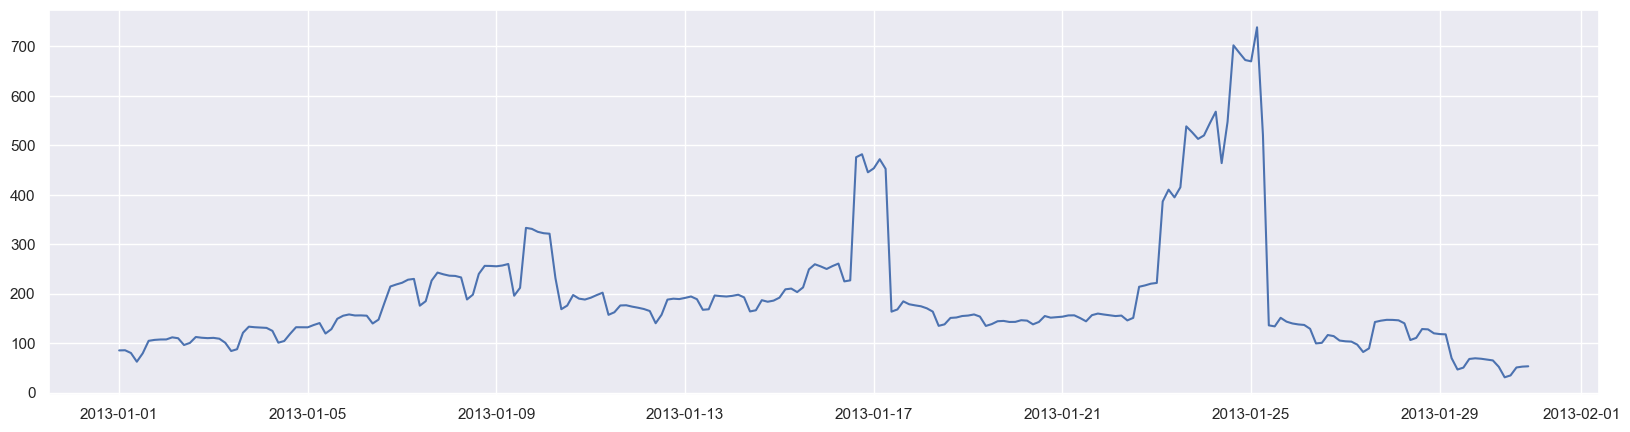

In [403]:
carrier_bus = 'AC'
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean(axis=1)
plt.plot(lmps[:8*30])
plt.show()

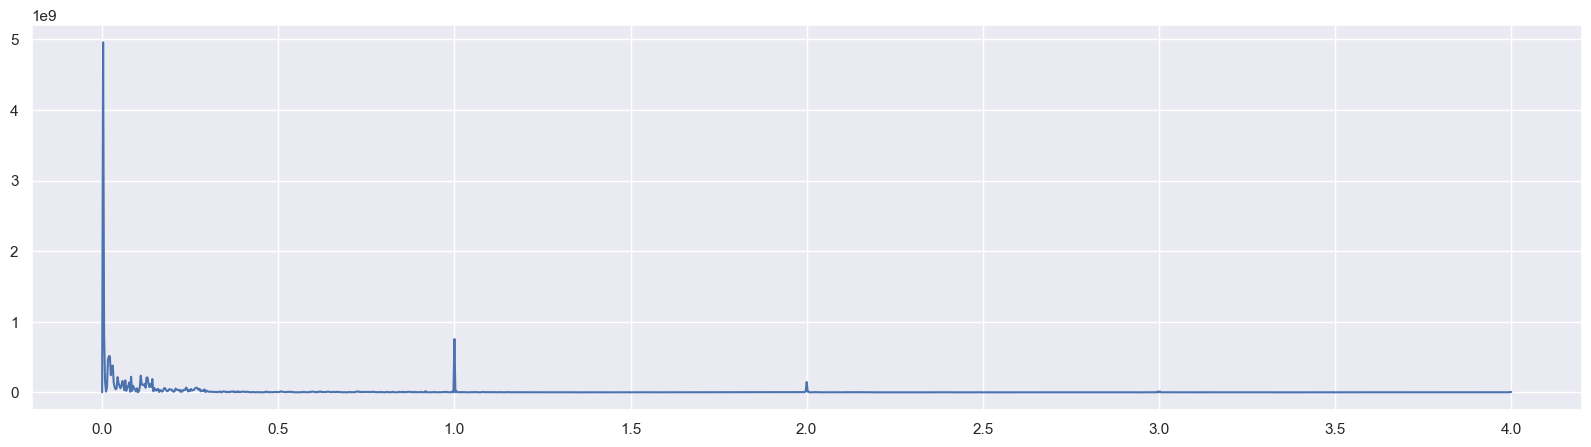

In [404]:
# choose df
df = lmps
# normalize
df = df - df.mean()

# make furier transform
ft = abs(pd.Series(np.fft.rfft(df), index=np.fft.rfftfreq(len(df), d=1/8))**2)
plt.plot(ft)
plt.show()

In [405]:
ft.sort_values(ascending=False)

0.002740    4.959092e+09
0.005479    8.430564e+08
1.000000    7.551992e+08
0.019178    5.116171e+08
0.021918    5.100107e+08
                ...     
3.213699    5.665993e+02
3.652055    3.639328e+02
3.605479    1.949450e+02
3.843836    1.114417e+02
0.000000    1.201087e-20
Length: 1461, dtype: float64

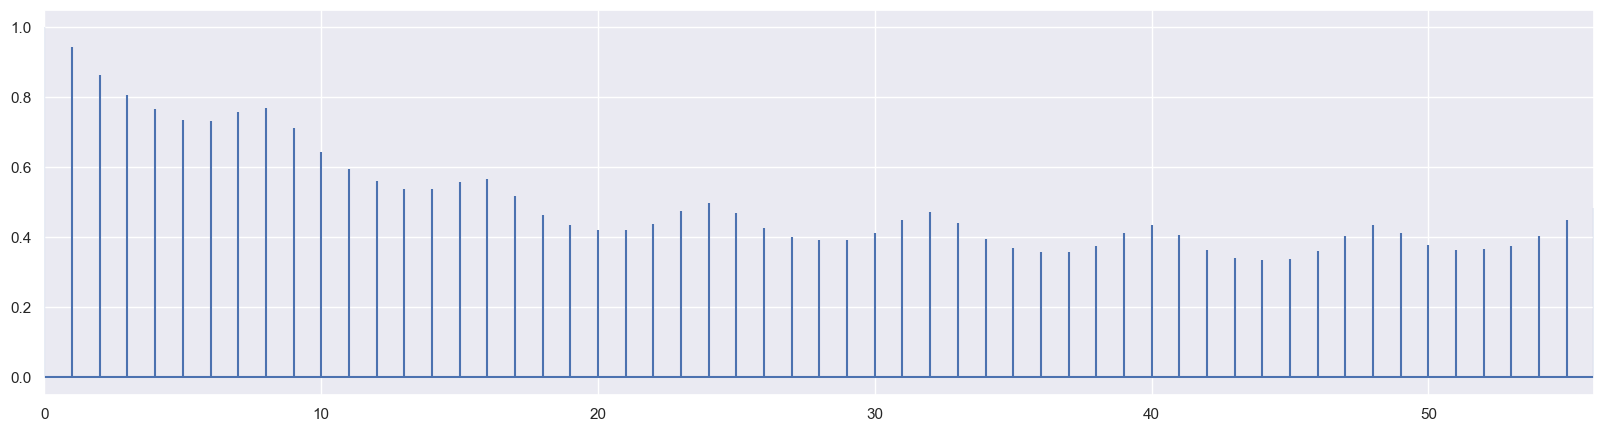

In [406]:
plt.acorr(df.values, maxlags=8*7)
plt.xlim([0,8*7])
plt.show()

### Congestion rent
Additionally: Calculate congestion rents for link components: price difference i-j * flow i-j
ToDo: maybe also for line components?

In [407]:
# congestion rent makes only sense if link has only 2 buses; definition of cr is otherwise unclear
carriers = n.links.carrier[n.links.bus3 == ""].unique()
cr_res1 = pd.DataFrame(index = range(1), columns=carriers)

for carrier in carriers:
    cr_res1[carrier] = congestion_rent_link(n,carrier).sum().sum()

In [408]:
cr_res1 = cr_res1.sort_values(by=0, axis='columns', ascending=False)

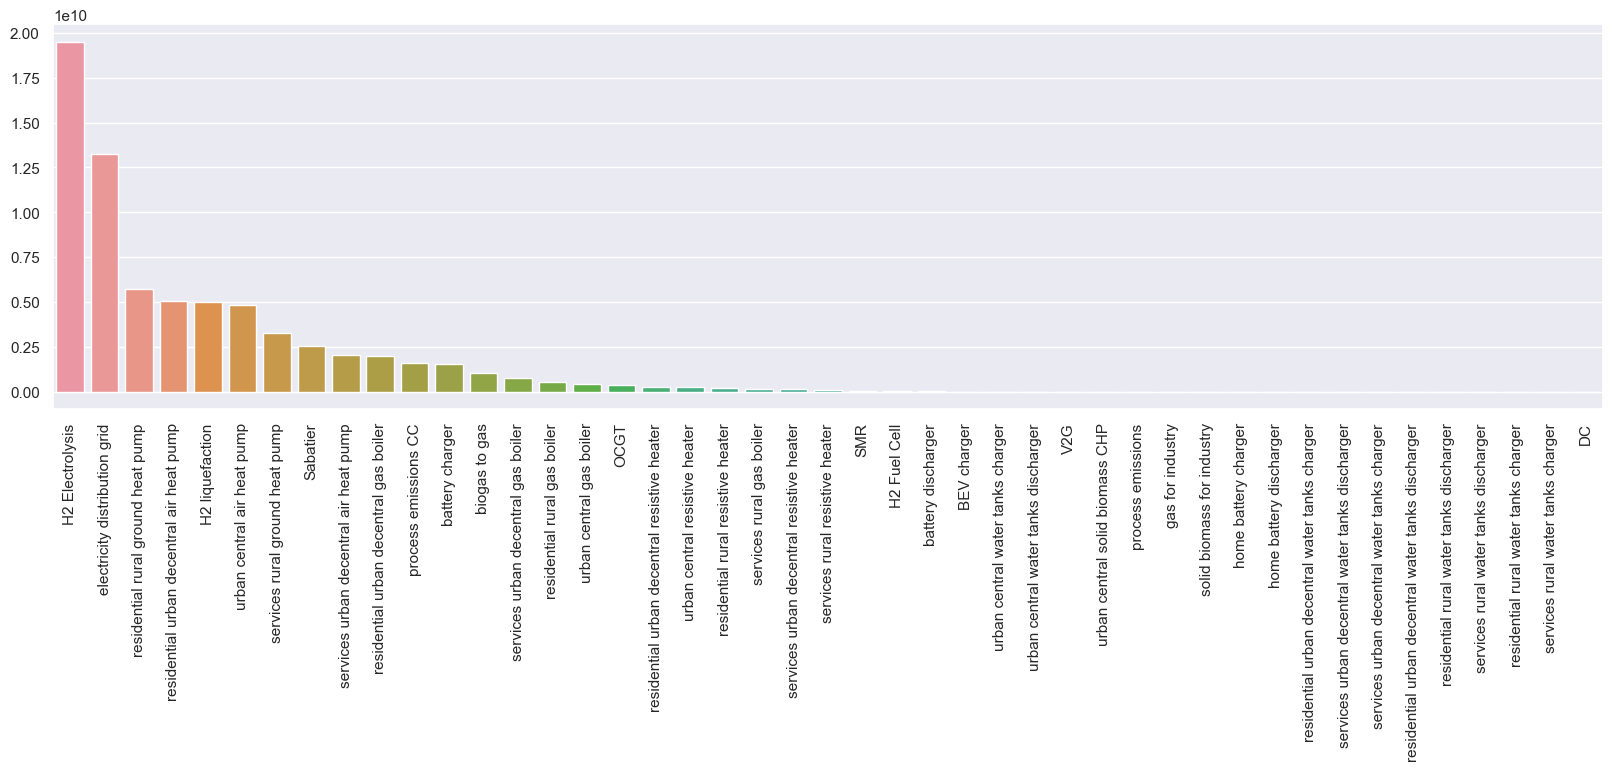

In [409]:
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(data=cr_res1)
ticks = plt.xticks(rotation=90)

__Findings__
- negative values for some technologies: OCGT, water tanks, battery charger but in much smaller magnitude than positive values (maybe due to numeric inaccuracy?)

In [410]:
# Congestion rent by region
cr_regions_onshore = onshore_regions.copy().rename(columns={"name": "location"})

for carrier in carriers:
    cr_regions = congestion_rent_link(n,carrier).sum()

    if n.buses.loc[cr_regions.index.map(n.links.bus0)].location.values[0] == 'EU':
        bus = "bus1"
    else:
        bus = "bus0"

    cr_regions = pd.concat([cr_regions,n.links.loc[cr_regions.index][bus]], axis=1).rename(columns={0: f"{carrier}_cr"})
    cr_regions["location"] = n.buses.loc[cr_regions.index.map(n.links[bus])].location.values
    # for some carrier e.g. "DC" the locations occur several times in the index -> take sum
    cr_regions = cr_regions.groupby(by=["location"], axis="index").sum()
    cr_regions_onshore[f"{carrier}_cr"] = cr_regions[f"{carrier}_cr"]
cr_regions_onshore.head(3)
    # TODO: For plotting the cr into a map which bus should be used? bus0, where the energy comes from or bus1 where the energy goes to? For some carriers e.g. Fischer-Tropsch they are not in the same region (EU bus)

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                         coords location  DC_cr      OCGT_cr  \
name                                                                           
AL0 0    (20.00648437943388, 41.14563914300007)    AL0 0    NaN    33.119340   
AT0 0  (15.700718667666258, 47.896990619088925)    AT0 0    NaN    95.440126   
AT0 1   (10.379200993764837, 47.18231496200006)    AT0 1    NaN  2507.759207   

       H2 Electrolysis_cr  H2 Fuel Cell_cr  battery charger_cr  \
name                                                             
AL0 0        5.753717e+07      -367.767894        3.464495e+07   
AT0 0        5.961820e+07      -365.643646        2.660615e+04   
AT0 1        2.992512e+06      -537.693753        7.541187e+06   

       battery discharger_cr   Sabatier_cr  ...  biogas to gas_cr  \
name                                        ...                     
AL0 0           34956.799709  1.342660e+07  ...               NaN   
AT0 0            1048.041194  3.348849e+06  ...               NaN   
AT0 1          138762.719384  9.170989e+04  ...               NaN   

       urban central solid biomass CHP_cr  solid biomass for industry_cr  \
name                                                                       
AL0 0                         1278.787475                            NaN   
AT0 0                         1375.459198                            NaN   
AT0 1                         1182.530598                            NaN   

       gas for industry_cr  H2 liquefaction_cr  process emissions_cr  \
name                                                                   
AL0 0                  NaN        1.891549e+06                   NaN   
AT0 0                  NaN        1.354453e+06                   NaN   
AT0 1                  NaN        1.631584e+05                   NaN   

       process emissions CC_cr  electricity distribution grid_cr  \
name                                                               
AL0 0                      NaN                      1.401134e+07   
AT0 0                      NaN                      1.486700e+08   
AT0 1                      NaN                      1.775257e+07   

       home battery charger_cr  home battery discharger_cr  
name                                                        
AL0 0              -352.001211                 -499.663643  
AT0 0              -429.846793                 -540.031913  
AT0 1              -416.792987                 -512.694656  

[3 rows x 48 columns]

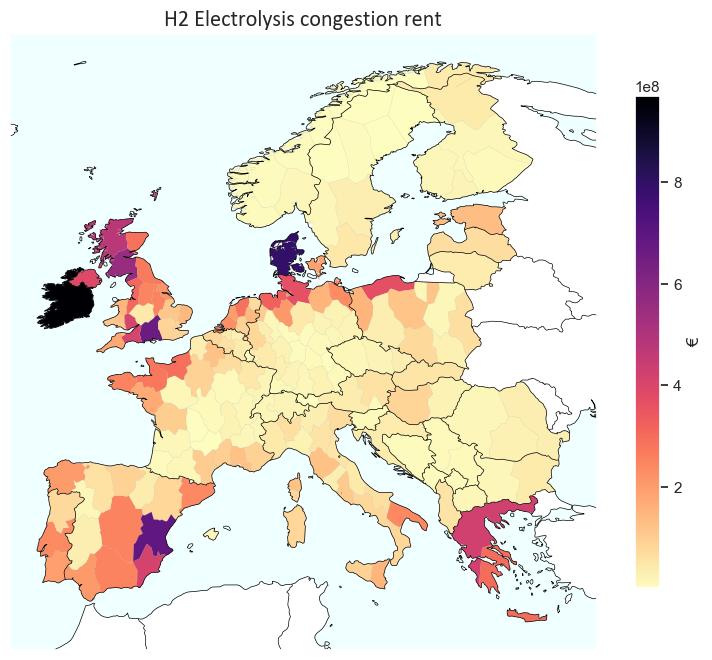

In [411]:
carrier = "H2 Electrolysis"

fig = plt.figure(figsize=(10, 8))

crs = ccrs.EqualEarth()
ax = plt.axes(projection=ccrs.EqualEarth()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} congestion rent", fontsize=16, **font1)

cr_regions_onshore.to_crs(crs.proj4_init).plot(column=f"{carrier}_cr",
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€",
                        'orientation': "vertical",
                                  'shrink' : 0.8})

plt.show()
# TODO: Would be interesting to plot a map with the location of the capacity of the corresponding carrier next to it; probably there is a correlation between higher capacity and higher cr

In [412]:
cr_regions_onshore[f"{carrier}_cr"].sort_values(ascending=False)

name
IE4 0     9.697672e+08
DK0 0     7.952162e+08
ES0 8     6.874895e+08
GB5 10    6.660884e+08
GB5 16    5.563028e+08
              ...     
SE3 1     2.215760e+06
NO3 1     2.166030e+06
SE3 5     2.047534e+06
SE3 7     1.280374e+06
SE3 4     1.087271e+06
Name: H2 Electrolysis_cr, Length: 181, dtype: float64

__Findings:__
- __H2 Electrolysis:__  Highest values in IRL, GBR and DNK; General higher values in the coastal area of mainland Europe (PRT, ESP, FRA, NLD, DEU, POL, GRC); very low values in the inner mainland and scandinavia
- __electricity distribution grid:__ no strong pattern; highest values for north/middle (FR0 1) and GB5 13; there might be soe correlation with higher cr in population-intensive regions an
- __Fischer-Tropsch:__ Comparable to H2 Electrolysis; Highest values in DNK & GBR; especialle higher values on the resource receiving party of the european coastline (Atlantic coast and GRC)
- __urban central solid biomass CHP CC:__ High values for parts of DEU, CZE, AUT, ITA, SVK & HUN; Very low values for west europe UK and scandinavia
- residential rural ground heat pump:
- residential urban decentral air heat pump:
- H2 liquefaction:
- urban central air heat pump:
- urban central gas CHP:

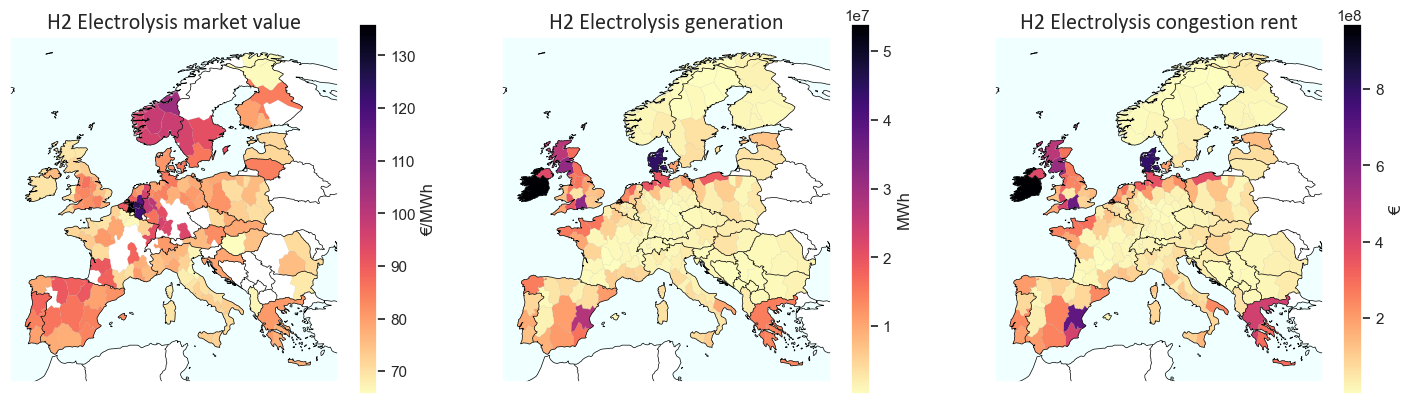

In [413]:
# summarising plot with mv, gen and cr
carrier="H2 Electrolysis"
# "battery discharger" # "battery charger" # "H2 Fuel Cell" #"Fischer-Tropsch" #"OCGT" #H2 Electrolysis" # H2 Electrolysis, H2 Fuel Cell
carriers=[carrier , f"{carrier}_gen", f"{carrier}_cr"]

fig, axs = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    if i==0:
        title = f"{carrier} market value"
        label = "€/MWh"
        df = mv_regions_onshore
    elif i==1:
        title = f"{carrier} generation"
        label = "MWh"
        df = mv_regions_onshore
    else:
        title = f"{carrier} congestion rent"
        label = "€"
        df = cr_regions_onshore

    args = dict(column=carriers[i],
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':label,
                        'orientation': "vertical",
                                  'shrink' : 0.3}
                )

    ax.set_title(title, fontsize=16, **font1)
    df.to_crs(crs.proj4_init).plot(**args)

plt.show()

### Two component analysis (Scatter)

#### Scatterplot: market value and
scatterplot of the market value and the generation for the 181 regions (if both values are present)

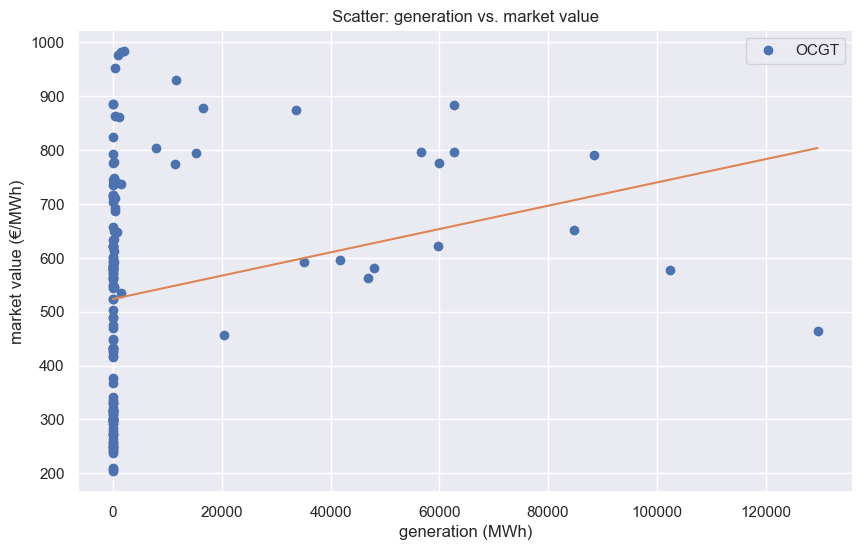

In [414]:
carrier = "OCGT" # "battery charger" # "OCGT"# "H2 Electrolysis" #"ror" # "onwind" # "solar"
x = mv_regions_onshore[f"{carrier}_gen"]
y = mv_regions_onshore[carrier]
x = x[x.notna() & y.notna()]
y = y[x.notna() & y.notna()]

fig = plt.figure(figsize=(10, 6))
p = np.poly1d(np.polyfit(x, y, 1))
t = np.linspace(start = 0, stop = int(max(x)), num = 1000)
plt.plot(x, y, 'o', label=carrier)
plt.plot(t, p(t), '-')
plt.title("Scatter: generation vs. market value")
plt.xlabel("generation (MWh)")
plt.ylabel("market value (€/MWh)")
plt.legend()
plt.show()

__Findings:__
- __solar:__ most generation less than 0.5 e^7; downward trend for the relationship between market value and generation
- __onwind:__ most gen < 2 e^7 MWh; clear downward trend
- __ror:__ mv between 60 and 150 €/MWh; no trend
- __H2 Electrolysis:__ gen mostly < 2 e^7; slight downward trend
- __OCGT:__ mostly very low gen; clear upward trend
- __battery charger:__ no clear trend (slightly downward)
- __SMR:__ most gen < 10000 MWh; clear upward trend

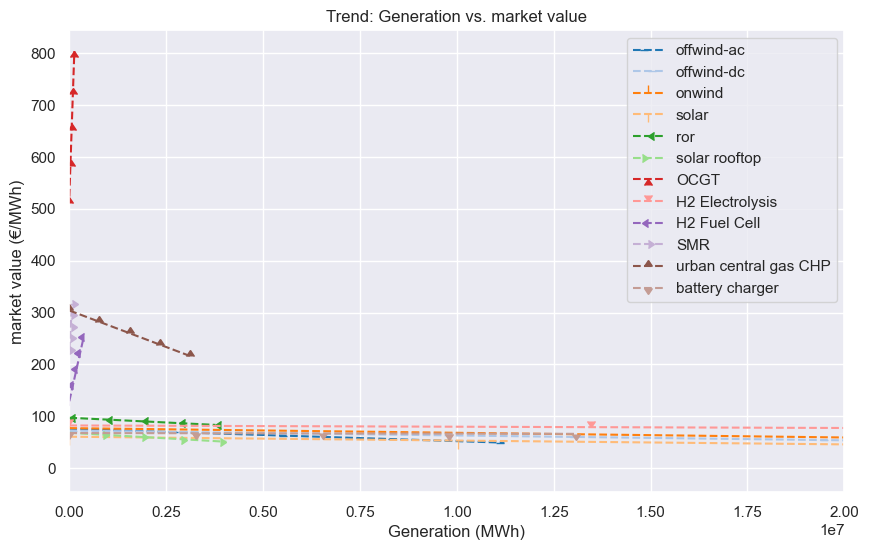

In [415]:
# comparing plot:
carriers = car_gen_vre.copy() + car_link_imp1.copy()
carriers = [e for e in carriers if e not in ["Fischer-Tropsch", "Sabatier"]]
colors = matplotlib.cm.tab20(range(len(carriers)))

plt.figure(figsize=(10, 6))

for carrier, i in zip(carriers, np.arange(0,len(carriers)-1)):
    x = mv_regions_onshore[f"{carrier}_gen"]
    y = mv_regions_onshore[carrier]
    x = x[x.notna() & y.notna()]
    y = y[x.notna() & y.notna()]

    p = np.poly1d(np.polyfit(x, y, 1))
    t = np.linspace(start = 0, stop = int(max(x)), num = 5)
    plt.plot(t, p(t), '--', label=carrier, color=colors[i], marker=i)

plt.title("Trend: Generation vs. market value")
plt.xlabel("Generation (MWh)")
plt.ylabel("market value (€/MWh)")
#plt.ylim([0,600])
plt.xlim([0,2*10**7])
plt.legend()
plt.show()

#### Scatterplot: market value and full load hours

In [416]:
th = 0.9

# get full_load hours (generators)
for carrier in n.generators.carrier.unique():
    gen = n.generators_t.p[n.generators[n.generators.carrier == carrier].index]
    # max_output = n.generators.p_nom_opt[n.generators.carrier == carrier]
    max_output = gen.max()

    # ts with p_nom_opt
    max_output_ts = gen.copy()
    for snap in n.storage_units_t.p.index:
        max_output_ts.loc[snap] = max_output[max_output_ts.columns]

    # calc full load hours
    flh = (gen >= th * max_output_ts).sum()
    flh.index = flh.index.map(n.generators.bus).map(n.buses.location)
    mv_regions_onshore[f"{carrier}_flh"] = flh

# links
for carrier in n.links.carrier.unique():
    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    # use p_nom_opt as indicator for full load hour
    # max_output = n.links.p_nom_opt[n.links.carrier == carrier]
    # use maximum of generation output as indicator fo full load hour
    max_output = gen.max()

    # ts with p_nom_opt
    max_output_ts = gen.copy()
    for snap in n.storage_units_t.p.index:
        max_output_ts.loc[snap] = max_output[max_output_ts.columns]

    # calc full load hours
    flh = (gen >= th * max_output_ts).sum()
    flh.index = flh.index.map(n.links.bus1).map(n.buses.location)
    # group duplicate index entries
    flh = flh.groupby(by=["Link"], axis="index").sum()
    mv_regions_onshore[f"{carrier}_flh"] = flh

mv_regions_onshore.head(3)

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                         coords   name  offwind-ac  \
name                                                                 
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0  126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0         NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1         NaN   

       offwind-ac_gen     onwind    onwind_gen      solar     solar_gen  \
name                                                                      
AL0 0        9.746004        NaN  5.041607e+00  44.628736  8.232590e+06   
AT0 0             NaN  83.457109  1.013197e+07  54.679083  3.400489e+06   
AT0 1             NaN        NaN  1.159912e-01  65.745903  5.758750e+06   

             ror  ...  gas for industry_flh  gas for industry CC_flh  \
name              ...                                                  
AL0 0        NaN  ...                   NaN                      NaN   
AT0 0  87.946522  ...                   NaN                      NaN   
AT0 1  97.282183  ...                   NaN                      NaN   

       H2 liquefaction_flh  Fischer-Tropsch_flh  process emissions_flh  \
name                                                                     
AL0 0                 2920                  NaN                    NaN   
AT0 0                 2920                  NaN                    NaN   
AT0 1                 2920                  NaN                    NaN   

       process emissions CC_flh  DAC_flh  electricity distribution grid_flh  \
name                                                                          
AL0 0                       NaN      NaN                                612   
AT0 0                       NaN      NaN                                872   
AT0 1                       NaN      NaN                               1104   

       home battery charger_flh  home battery discharger_flh  
name                                                          
AL0 0                         8                            1  
AT0 0                        33                            5  
AT0 1                       161                            1  

[3 rows x 205 columns]

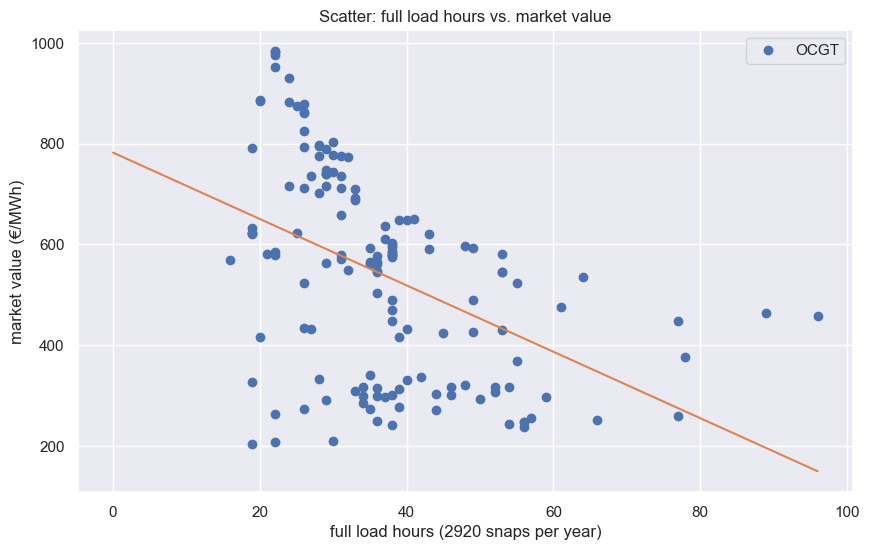

In [417]:
carrier = "OCGT"# "Fischer-Tropsch" # "OCGT" # "onwind" # "solar rooftop" # "solar"# "H2 Electrolysis" # "solar rooftop" # "ror"
x = mv_regions_onshore[f"{carrier}_flh"]
y = mv_regions_onshore[carrier]
x = x[x.notna() & y.notna()]
y = y[x.notna() & y.notna()]

fig = plt.figure(figsize=(10, 6))
p = np.poly1d(np.polyfit(x, y, 1))
t = np.linspace(start = 0, stop = int(max(x)), num = 1000)
plt.plot(x, y, 'o', label=carrier)
plt.plot(t, p(t), '-')
plt.title("Scatter: full load hours vs. market value")
plt.xlabel("full load hours (2920 snaps per year)")
plt.ylabel("market value (€/MWh)")
plt.legend()
plt.show()

__Findings:__
- with p_nom_opt the full load hours for many carriers are 0; maybe it is more valid to use the maximum output as the maximum capacity to compare to?
- for VRE the trend is mostly downwards, for technologies that can be regulated it is upwards
- __ror:__ flh either < 400 or around 1200; upward trend
- __solar / solar rooftop:__ flh > 150; downward trend
- __H2 Electrolysis:__ flh mostly in range(500,1000); upward trend
- __onwind:__ flh mostly < 100 and all < 500; clear downward trend
- __OCGT:__ flh in range (20,60); clear downward trend
- __Fischer-Tropsch:__ no single full load hour

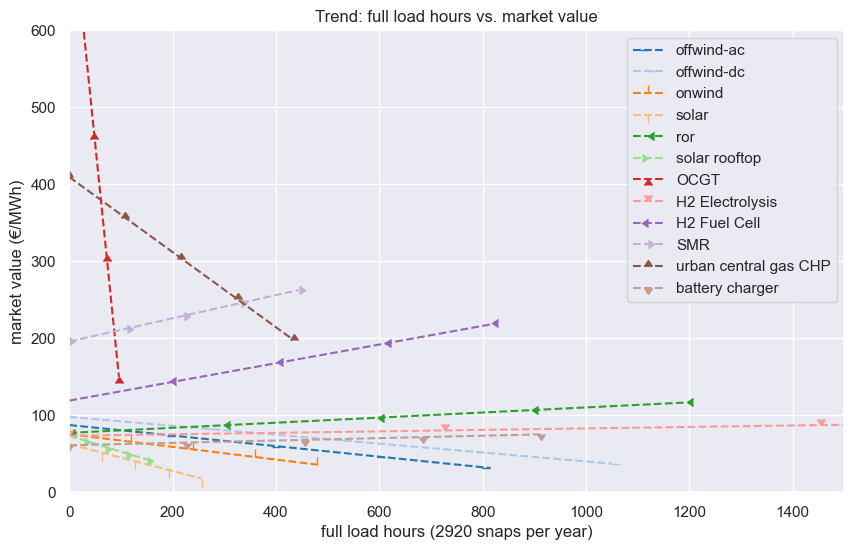

In [418]:
# comparing plot:
carriers = car_gen_vre.copy() + car_link_imp1.copy()
carriers = [e for e in carriers if e not in ["Fischer-Tropsch", "Sabatier"]]
colors = matplotlib.cm.tab20(range(len(carriers)))

plt.figure(figsize=(10, 6))

for carrier, i in zip(carriers, np.arange(0,len(carriers)-1)):
    x = mv_regions_onshore[f"{carrier}_flh"]
    y = mv_regions_onshore[carrier]
    x = x[x.notna() & y.notna()]
    y = y[x.notna() & y.notna()]

    p = np.poly1d(np.polyfit(x, y, 1))
    t = np.linspace(start = 0, stop = int(max(x)), num = 5)
    plt.plot(t, p(t), '--', label=carrier, color=colors[i], marker=i)

plt.title("Trend: full load hours vs. market value")
plt.xlabel("full load hours (2920 snaps per year)")
plt.ylabel("market value (€/MWh)")
plt.ylim([0,600])
plt.xlim([0,1500])
plt.legend()
plt.show()

__Findings:__
- strong downward trend for OCGT and urban central gas CHP
- strong upward trend for SMR and H2 Fuel Cell
- rather downward: solar, onwind, solar rooftop, offwind-ac, offwind-dc
- rather upward: ror, H2 Electrolysis, battery charger

__Implications:__
- non controllable technologies like vre cannot choos to run during times of high market values, therefore the mv rater decreases with more flh
- controllable energies like SMR, ror, H2 Electrolysis, battery charger can choose when to run adn therefore are more likely to run during times of high mv
- the strong downward trend of OCGT and central gas CHP (both controllable) can be explained by the fact that they are only running at very high mv already

### ToDo

In [419]:
#TODO: market value aggregated over carriers per country/region plot#
#TODO: GIF with same colorbar for all entries